In [23]:
%matplotlib inline
import pandas as pd
import numpy as np
import math
import re
import sys
import ast
 
import pycountry_convert as pc
import pycountry
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from geotext import GeoText
import datetime
import pickle
import nltk
import string
from tqdm import tqdm
import spacy
import en_core_web_sm
from spacy.matcher import PhraseMatcher
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')

#for plotting
import geopandas
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
from tqdm import tqdm
#import geopandas
from wordcloud import WordCloud, STOPWORDS
import random
import plotly.graph_objects as go
import plotly.express as px
import plotly
from plotly.graph_objs import *
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv( '../../Projet/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1' )

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (4,6,31,33,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.



### Column content

Here some useful information about the principals columns in the Global Terrorism Data Base

- eventid: A 12-digit Event ID system. First 8 numbers – date recorded “yyyymmdd”. Last 4 numbers – sequential case number for the given day (0001, 0002 etc).
- doubtterr, we dropped values that were not sure to be a terror attack.
- attacktype1, attacktype2, attacktype3: The general method of attack
- attacktype1_txt, attacktype2_txt, attacktype3_txt: The general method of attack and broad class of tactics used. 1= assassination, 2=hijacking, 3= kidnapping 4=barricade 5=bombing/explosion, 6=armed assault, t=unarmed assault, 8=facility&infrastructure attack, 9=unknown
- gname, gname2, gname3: The name of the group that carried out the attack
- claimed (1= claimed, 0=no claim), claim2, claim3
- weaptype1, weaptype2, weaptype3, weaptype4 (type of weapon used)
- weaptype1_txt, weaptype2_txt, weaptype3_txt, weaptype4_txt: General type of weapon used in the incident
- nkill: The number of total confirmed fatalities for the incident (including also perpetrators)
- nkillus: The number of U.S. citizens who died as a result of the incident
- nkillter: number of killed terrorists
- nwound: number of wounded
- property if property was damaged
- propextent (1= more than 1 billion dollars, 2=1million-1biollion dollars 3= minor less than 1 million, 4 unknown)
- propvalue numerical value of property dammage

## Load Data and cleaning

In [5]:
# cleaning the dates and creating a date column
df=df.rename(columns={'iday' : 'day','imonth' : 'month','iyear': 'year'})
df=df.set_index('eventid')

In [6]:
#creating a copy of df where all duplicates are dropped (duplicates compared over all columns)
df_approx=df.drop_duplicates(keep='first')

We will now merge the columns with the same type of content, we will have now instead claimed, claim2, claim3 a list of claims in a column named after the first repetition instance. 

In [7]:
# merging of columns
col_names = df_approx.columns.values.tolist()
d = {}

def add(mask, s):
    if mask not in d:
        d[mask] = []
    d[mask].append(s)
    
# keep in a dict the similar column names as lists with as keys the shared similar name    
for s in col_names:
    for pos in range(len(s)):
        add(s[:pos] + '?' + s[pos + 1:], s)
        add(s[:pos] + '?' + s[pos:], s)
    add(s + '?', s)
    
# for similar column names in the dict merge the content of the columns as list and drop the additional columns
for k, v in d.items():
    if len(v) > 1:
        df_approx[v[0]] = df_approx[v].values.tolist()
        df_approx[v[0]] = df_approx[v[0]].apply(lambda x: [i for i in x if i == i])
        df_approx = df_approx.drop(columns=v[1:])
df_approx.shape

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(177140, 87)

## To be (a terrorist) or not to be? GTD Definition of Terrorism and Inclusion Criteria

The GTD defines a terrorist attack as the threatened or actual use of illegal force and violence by
a non-state actor to attain a political, economic, religious, or social goal through fear, coercion,
or intimidation. In practice this means in order to consider an incident for inclusion in the GTD,
all three of the following attributes must be present:
* The incident must be intentional – the result of a conscious calculation on the part of a perpetrator.
* The incident must entail some level of violence or immediate threat of violence -including property violence, as well as violence against people.
* The perpetrators of the incidents must be sub-national actors. The database does not include acts of state terrorism.

In addition, at least two of the following three criteria must be present for an incident to be
included in the GTD:
**criterion1** The act must be aimed at attaining a political, economic, religious, or social goal. In terms of economic goals, the exclusive pursuit of profit does not satisfy this criterion. It must involve the pursuit of more profound, systemic economic change.

**criterion2** here must be evidence of an intention to coerce, intimidate, or convey some other message to a larger audience (or audiences) than the immediate victims. It is the act taken as a totality that is considered, irrespective if every individual involved in carrying out the act was aware of this intention. As long as any of the planners or decision-makers behind the attack intended to coerce, intimidate or publicize, the intentionality criterion is met.

**criterion3**The action must be outside the context of legitimate warfare activities. That is, the act must be outside the parameters permitted by international humanitarian law, insofar as it targets non-combatants

In [8]:
#only keep the attacks which are sure to be considered as terrorist attacks according to mention above
#leaves us with a 135554 attacks in all
print('the number of entries which are sure to be terror attacks using the doubtterr variable equal to 0:', len(df_approx.loc[df_approx.doubtterr==0]))

print('the number of entries which fulfill all 3 criteria', len(df_approx.loc[(df_approx.crit1.apply(lambda x: sum(x))==3)]))
print('the number of entries which fulfill at leaset 2 criteria', len(df_approx.loc[(df_approx.crit1.apply(lambda x: sum(x))>=2)]))

#as all attacks fill at least two of the criteria mentioned above, they are all considered terrorist attacks.
print('the number of entries that fulfill less than 2 criteria, and are therefore for sure not terrorist attacks: ',len(df_approx.loc[(df_approx.crit1.apply(lambda x: sum(x))<2)]))

the number of entries which are sure to be terror attacks using the doubtterr variable equal to 0: 135554
the number of entries which fulfill all 3 criteria 151512
the number of entries which fulfill at leaset 2 criteria 177140
the number of entries that fulfill less than 2 criteria, and are therefore for sure not terrorist attacks:  0


In [9]:
print('the length of the full dataset: ', len(df_approx))

the length of the full dataset:  177140


This justifies that we do not drop data solely based on the "doubtterr" variable being equal to 0. all entries that we have are considered to be terrorist attacks according to the definition above.

## Clean year feature

In [10]:
df_approx=df_approx.drop(columns=['summary','gsubname','compclaim',\
                        'propcomment','ransomamt','addnotes','scite1',\
                        'dbsource','divert','kidhijcountry','alternative','alternative_txt'])

In [11]:
df_approx.head()

year  month  day approxdate  extended resolution  country  \
eventid                                                                   
197000000001  1970      7    2        NaN         0        NaN       58   
197000000002  1970      0    0        NaN         0        NaN      130   
197001000001  1970      1    0        NaN         0        NaN      160   
197001000002  1970      1    0        NaN         0        NaN       78   
197001000003  1970      1    0        NaN         0        NaN      101   

                     country_txt  region                   region_txt  ...  \
eventid                                                                ...   
197000000001  Dominican Republic       2  Central America & Caribbean  ...   
197000000002              Mexico       1                North America  ...   
197001000001         Philippines       5               Southeast Asia  ...   
197001000002              Greece       8               Western Europe  ...   
197001000003               Japan       4                    East Asia  ...   

             ransompaidus ransomnote  hostkidoutcome  hostkidoutcome_txt  \
eventid                                                                    
197000000001          NaN        NaN             NaN                 NaN   
197000000002          NaN        NaN             NaN                 NaN   
197001000001          NaN        NaN             NaN                 NaN   
197001000002          NaN        NaN             NaN                 NaN   
197001000003          NaN        NaN             NaN                 NaN   

              nreleased  INT_LOG INT_IDEO INT_MISC  INT_ANY  related  
eventid                                                               
197000000001        NaN        0        0        0        0      NaN  
197000000002        NaN        0        1        1        1      NaN  
197001000001        NaN       -9       -9        1        1      NaN  
197001000002        NaN       -9       -9        1        1      NaN  
197001000003        NaN       -9       -9        1        1      NaN  

[5 rows x 75 columns]

In [12]:
#where day month and year are properly filled in, a date-type is created and stored in a new column "date"
df_approx['date']=pd.to_datetime(df_approx[['day','month','year']], exact=False, errors = 'coerce')

#Clean dates with "/" inside the approx date
#get approxdates where there is no proper "date" and the approxdate is inferior to a len of 12 characters
#the dates are in the following format month/day/year ../../..
df_approx['approxdate']=df_approx['approxdate'].where(df_approx.loc[df_approx['date'].isna()]['approxdate'].str.len()<12)

#where there is a "/" within the approxdate, modify to a datetime and stock as date
pd.to_datetime(df_approx.loc[df_approx['approxdate'].str.contains('/',na=False)]['approxdate'])
df_approx['date']=df_approx['date'].combine_first(df_approx['approxdate'])

# if the attack takes place over multiple days transform the resolution date into a date object
df_approx['resolution']=pd.to_datetime(df_approx.resolution, exact=False, errors = 'coerce')

#addition of a span column for the attacks where there is a start date and resolution date
df_approx['span']=df_approx['resolution']-df_approx['date']

Clean data has been saved in pickle file 

In [14]:
df_approx.to_pickle("../../data/df_approx.pkl")  

## Number of terrorist attacks across years

Looking over the years from 1970 to 2017, we can see an increase of incidents, especially in recent years starting around 2010.
There is a strange gap in the data in 1993. Looking into terror attacks in 1993, we can clearly see that it is not that no attacks happened during this year (ex, attack on worldtrade center on February 23 1993 https://www.state.gov/1993-world-trade-center-bombing/) Reading into the information on the dataset, we found that the data was lost prior to addition to the dataset. This explanes the gap observed. 
(https://www.start.umd.edu/gtd/downloads/Codebook.pdf)



Text(0.5, 1.0, 'count of terror attacks per year')

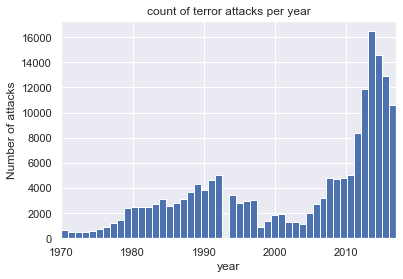

In [29]:
f= plt.hist(df_approx['year'], bins=48)
plt.xlim(df_approx.year.min(), df_approx.year.max())
plt.xlabel('year')
plt.ylabel('Number of attacks')
plt.title('count of terror attacks per year')


Looking over the years from 1970 to 2017, we can see an increase of incidents, between recent years starting around 2010 to to 2013. Interestingly, the trend seems to descend between 2013 to 2017.
There is a strange gap in the data in 1993. Looking into terror attacks in 1993, we can clearly see that it is not that no attacks happened during this year (ex, attack on worldtrade center on February 23 1993 https://www.state.gov/1993-world-trade-center-bombing/) Reading into the information on the dataset, we found that the data was lost prior to addition to the dataset. This explanes the gap observed. 
(https://www.start.umd.edu/gtd/downloads/Codebook.pdf)
We therefore decided to scrape the data from wikipedia concerning the attacks from the year 1993


### Scraping data from wikipedia to complete the information from 1993

As data from 1993 in the Global Terrorism Dataset is missing, then we try here to recover at least a small amount of data from Wikiepedia. We used the url: https://en.wikipedia.org/wiki/List_of_terrorist_incidents_in_1993 and extracted all information in the table of terror attacks.

Then we just clean the data a bit to make it consistant with the format of the Gloabl Terrorism Dataset. 

In [8]:
url = 'https://en.wikipedia.org/wiki/List_of_terrorist_incidents_in_1993'
df_1993 = pd.read_html(url)[1]

In [9]:
df_1993 = df_1993.iloc[1:]
df_1993.rename(columns={'Date':'approxdate', 'Type':'attacktype1_txt', 'Dead':'nkill', 'Injured':'nwound', 'Location':'location', 'Details':'summary',
                        'Perpetrator':'gname', 'Part of':'motive'}, inplace=True)

In [10]:
def fill_missing_dates(row):
    s = row['approxdate']
    s = re.split("[, \–\-!?:]+", s)
    day = 0
    month = 0
    for sub in s:
        if day==0 and sub.isdigit():
            day = int(sub)
        elif month == 0:
            month = datetime.datetime.strptime(sub, '%B').month
    return pd.Series([day, month])

In [11]:
df_1993['year'] = 1993
df_1993[['day', 'month']]=df_1993.apply(fill_missing_dates, axis=1)
df_1993['date']=pd.to_datetime(df_1993[['year', 'month', 'day']], format="%Y%m%d")

In [12]:
#functions to extract the number of killed and wounded people
def clean_nkill(row):
    s = row['nkill']
    nkill = 0
    nkillter = 0
    try : 
        nkill = int(s)
    except:
        nkill = int(s[:s.find('(')])
        if '+' in s:
            nkillter = int(re.findall('\d+', s[s.find('(')+1:s.find(')')])[0])
            nkill += nkillter
        else:
            nkillter = nkill
    return pd.Series([nkill, nkillter])

def clean_nwound(row):
    s = row['nwound']
    nwound = 0
    ishostkid = 0
    try:
        nwound = int(s)
    except: 
        try :
            nwound = int(re.findall('\d+', s)[0])
            if 'Kidnapped' in s:
                ishostkid = nwound
        except: 
            nwound = np.nan
                           
    return pd.Series([nwound, ishostkid])

#function to create an ID for the event to be relevant to the other attack formats
def create_id(row):
    y=row['year']
    m=row['month']
    d=row['day']
    i=row.name
    event_id = "{:0>4}".format(y)+"{:0>2}".format(int(m))+"{:0>2}".format(int(d))+"{:0>4}".format(int(i))
    
    if pd.isnull(event_id):
        event_id = "{:0>10}".format(1993)+"{:0>2}".format(int(i))

    return event_id

In [13]:
df_1993[['nkill', 'nkillter']]=df_1993.apply(clean_nkill, axis=1)
df_1993[['nwound', 'ishostkid']]=df_1993.apply(clean_nwound, axis=1)
df_1993['attacktype1_txt']=df_1993['attacktype1_txt'].apply(lambda x: x.lower())

In [14]:
df_1993['attacktype1_txt'].value_counts()

bombing                     5
bombings                    3
ambush                      2
suicide bombing             2
arson                       2
shooting                    2
truck bombing               2
mass shooting               2
attempted attack            1
car bombings                1
mass shooting, arson        1
letter bomb, car bombing    1
land mine                   1
massacre                    1
hijacking                   1
kidnapping and murder       1
assassination attempt       1
Name: attacktype1_txt, dtype: int64

To fill in the `attack_type`column with text in the new dataset, we just defined a dictionary with the right keys used in GTD and the corresponding text, 

In [15]:
dict_type = {1:'Assassination', 2:'Hijacking', 3:'Kidnapping', 4:'Barricade', 5:'Bombing/Explosion ',
             6:'Armed assault', 7:'Unarmed assault', 8:'Facility/Infrastructure Attack', 9:'Unknown'}

In [16]:
df_1993.loc[df_1993['attacktype1_txt'].str.contains('bomb'), 'attacktype1_txt'] = dict_type[5]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('ambush'), 'attacktype1_txt'] = dict_type[6]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('arson'), 'attacktype1_txt'] = dict_type[8]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('shooting'), 'attacktype1_txt'] = dict_type[6]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('attack'), 'attacktype1_txt'] = dict_type[6]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('hijacking'), 'attacktype1_txt'] = dict_type[2]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('kidnapping'), 'attacktype1_txt'] = dict_type[3]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('assassination'), 'attacktype1_txt'] = dict_type[1]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('massacre'), 'attacktype1_txt'] = dict_type[1]
df_1993.loc[df_1993['attacktype1_txt'].str.contains('mine'), 'attacktype1_txt'] = dict_type[5]

In [17]:
dict_type2 = {v : k for k, v in dict_type.items()}
df_1993['attacktype1'] = df_1993['attacktype1_txt'].apply(lambda v : dict_type2[v])
df_1993['eventid']= df_1993.reset_index().fillna(0).apply(create_id, axis=1)
df_1993['gname'] = df_1993['gname'].replace('Unknown', np.nan)
df_1993['gname'] = df_1993['gname'].apply(lambda x : [x])
df_1993['attacktype1_txt'] = df_1993['attacktype1_txt'].apply(lambda x : [x])

Now that we have cleaned the data from 1993, we can merge it to the Global Terrorism Dataset and save it as a csv, to use for further analysis. 

In [22]:
file = open('../../data/df_approx.csv', 'rb')
df_approx = pd.read_csv(file)

C:\Users\Christelle\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (5,7,68,78) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
df_terrorismm = pd.read_csv( '../../data/globalterrorismdb_0718dist.csv', encoding='ISO-8859-1' )
df_terrorismm = df_terrorismm[['eventid', 'summary']]
df_approx = pd.merge(df_approx, df_terrorismm, on='eventid')

In [26]:
df_approx_completed = df_approx.append(df_1993, sort=False)
df_approx_completed.to_csv("data/df_approx_completed.csv")

## Verification that in our completed dataset contains attacks occuring in 1993 

In [26]:
df = pd.read_csv( '../../data/df_approx_completed.csv', encoding='ISO-8859-1', low_memory=False)

In [27]:
# CSV pass list to string, reconvert useful columns
df['natlty1_txt'] = df['natlty1_txt'].dropna().apply(lambda x: ast.literal_eval(str(x)))
df['weaptype1_txt'] = df['weaptype1_txt'].dropna().apply(lambda x: ast.literal_eval(str(x)))
df['targtype1_txt'] = df['targtype1_txt'].dropna().apply(lambda x: ast.literal_eval(str(x)))
df['targsubtype1_txt'] = df['targsubtype1_txt'].dropna().apply(lambda x: ast.literal_eval(str(x)))
# Pass list of float to list of int
df['targsubtype1'] = df['targsubtype1'].dropna().apply(lambda x: ast.literal_eval(x))
df['targsubtype1'].dropna(inplace = True)
df['targsubtype1'] = df['targsubtype1'].apply(lambda x : list(map(int, x)))
# Define the victims as total kills - attackants killed
df['nkillvi'] = df['nkill'] - df['nkillter'] 
df['nwoundvi'] = df['nwound'] - df['nwoundte'] 

In [46]:
fig = go.Figure(data=[go.Histogram(x=df['year'])])
fig.update_layout(height = 800,
    title_text='Count of terror attacks per year',
    xaxis_title_text='Year', 
    yaxis_title_text='Count of attacks', 
    bargroupgap=0.1
)
fig.show()
# Save
plotly.offline.plot(fig, filename = '../plots/CasualtiesPerYear.html', auto_open=False)

'../plots/CasualtiesPerYear.html'

We can see that a few attacks have been added in 1993, but it is not comparable to the rest of the attacks.
The data from wikipedia is clearly less complete, than the global terrorism database. We will need to be careful with any type of analysis concerning the amount of attacks in link with time

### Link of human casualties with an increase in terrorist attacks
We observed before that there is a clear increase of the number of terrorist attacks over the more recent years. What does this imply for the general population? Are there more casualties as the number of attacks increase? Are the extent of the attacks constant, or are there more "small" attacks over the recent years? 

Do all attacks result in injured victims? If not, what is the percentage of attacks which result in the death or wounded victims ?

In [30]:
df_approx=df

In [31]:
#number of cases in which victims were killed
killed_victims=(df_approx.nkill.dropna()>0).value_counts()

Text(0.5, 1.0, 'attacks resulting in death')

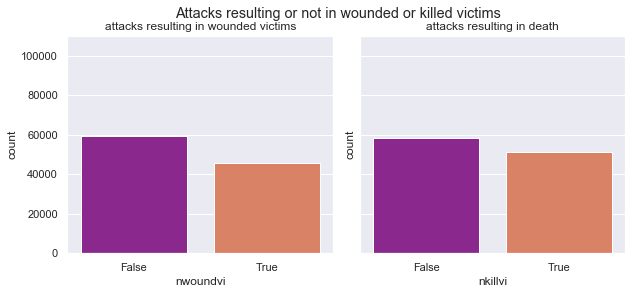

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (10,4), sharey=True)
fig.suptitle('Attacks resulting or not in wounded or killed victims')
plt.gcf().subplots_adjust(wspace = 0.1)

fig=sns.countplot(df_approx.nwoundvi.dropna()>0, palette='plasma', ax=ax1)
fig=sns.countplot(df_approx.nkillvi.dropna()>0,palette='plasma', ax=ax2)

ax1.set_ylim(0,110000)
ax1.set_title('attacks resulting in wounded victims')
ax2.set_ylim(0,110000)
ax2.set_title('attacks resulting in death')

looking into the amount of attacks that result in victims dying, we can see that it is about the same amount of attacks which don't resuslt in death as to the ones which do. Doing the same with the amount of attacks resulting in wounded victims, we can clearly see that there are more attacks which don't result in wounded victims than attacks which do. This could be a surprising result, seeing that many terrorist attacks do not concretely result in human casualties. This way of looking at it however is purely binary, meaning that the amount of wounded or dead is not taken into consideration. It might also be interesting to identify if the attacks which did not result in any human casualties, are considered as a "successful" attack or not. 

In [33]:
(df_approx.nwoundvi.dropna()>0).value_counts()

False    59185
True     45783
Name: nwoundvi, dtype: int64

In [38]:
# Select data from 1997 as it is the period of interest for us
df_approx = df_approx.loc[df.year > 1996]
df_approx['gname'] = df_approx['gname'].dropna().apply(lambda x: ast.literal_eval(str(x)))

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
# creation of casualties dataframe
df_casualties=pd.DataFrame(index=df_approx.year.unique())
df_casualties=df_casualties.sort_index(ascending=True)
df_casualties['killed']=df_approx.groupby('year')['nkillvi'].agg('sum')
df_casualties['wounded']=df_approx.groupby('year')['nwoundvi'].agg('sum')

df_cas = df_casualties
df_casualties.reset_index(inplace=True)
df_casualties.rename(columns={'index' : 'year'}, inplace = True)


In [44]:
# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_casualties["year"], y=df_casualties["killed"],
                    mode='lines',
                    name='killed'))
fig.add_trace(go.Scatter(x=df_casualties["year"], y=df_casualties["wounded"],
                    mode='lines',
                    name='wounded'))
fig.update_layout(height = 800,
    title_text='Casualties according to year',
    xaxis_title_text='year', 
    yaxis_title_text='human casualties', 
    bargroupgap=0.1
)
# Save
fig.show()
plotly.offline.plot(fig, filename = '../plots/CasualtiesPerYear.html', auto_open=False)

'../plots/CasualtiesPerYear.html'

The amount of wounded follows the amount of killed victims quite closely. Interestingly in the early 2000s there is a high peak of wounded, and we hypothesize that this is due to the extent of the terrorist attack on the worldtrade center in 2001. Further analysis will be required to confirm this hypothesis however. 
We have also seen that the number of terror attacks continue to increase up to 2013, which makes sense as it follows very closely the number of attacks per year. 
To confirm this, we will now also look into the average number of casualties per attack over the years.

In [49]:
# Creation of casualties dataframe
df_casualties=pd.DataFrame(index=df_approx.year.unique())
df_casualties=df_casualties.sort_index(ascending=True)
df_casualties['killed']=df_approx.groupby('year')['nkillvi'].agg('sum')
df_casualties['wounded']=df_approx.groupby('year')['nwoundvi'].agg('sum')
df_casualties_av=pd.DataFrame(index=df_approx.year.unique())
df_casualties_av=df_casualties_av.sort_index(ascending=True)

# Normalize per year wrt the number of attacks
df_casualties_av['av killed (per attack)']=df_casualties['killed']/df_approx.year.value_counts()
df_casualties_av['av wounded (per attack)']=df_casualties['wounded']/df_approx.year.value_counts()
df_casualties_av.reset_index(inplace=True)
df_casualties_av.rename(columns={'index' : 'year'}, inplace = True)

In [50]:
# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_casualties_av["year"], y=df_casualties_av["av killed (per attack)"],
                    mode='lines',
                    name='killed'))
fig.add_trace(go.Scatter(x=df_casualties_av["year"], y=df_casualties_av["av wounded (per attack)"],
                    mode='lines',
                    name='wounded'))
fig.update_layout(height = 800,
    title_text='Average casualties per attack according to year',
    xaxis_title_text='year', 
    yaxis_title_text='human casualties', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/Casualties_NormPerYear.html', auto_open=False)

'../plots/Casualties_NormPerYear.html'

observing the average number of casualties (both wounded and killed) due to attacks, we can tell that around 2000, there were peaks of years where there were a larger number of people touched per incident than the other years. This could follow the hypothesis evoqued in the point before, that there may be a few larger attacks which happened during this period (ex, 9.11.2001), which bring the number of casualties of that year, up significantly, eventhough there were not more attacks per se.  

### Link of propreties dammages with an increase in terrorist attacks

We can also measure the impact of an attack based on the value of the damaged propreties. An attack may have destroyed important public buildings without dead or wounded for example.

In [51]:
# Creation of propriety value dataframe
df_propvalue=pd.DataFrame(index=df_approx.year.unique())
df_propvalue=df_propvalue.sort_index(ascending=True)
df_propvalue['propvalue']=df_approx.groupby('year')['propvalue'].agg('sum')

# Normalize per year wrt the number of attacks
df_propvalue_av=pd.DataFrame(index=df_approx.year.unique())
df_propvalue_av=df_propvalue_av.sort_index()
df_propvalue_av['average property dammage (per attack) in USD']=df_propvalue['propvalue']/ \
                                                                    df_approx.year.value_counts()

In [52]:
# Plot
df_propvalue.reset_index(inplace=True)
df_propvalue.rename(columns={'index' : 'year'}, inplace = True)
fig = px.line(df_propvalue, x="year", y='propvalue')
fig.update_layout(height = 800,
    title_text='Property dammage',
    xaxis_title_text='year', 
    yaxis_title_text='Value of property dammage (in USD)', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/PropretyPerYear.html', auto_open=False)

'../plots/PropretyPerYear.html'

In [53]:
# Plot
df_propvalue_av.reset_index(inplace=True)
df_propvalue_av.rename(columns={'index' : 'year'}, inplace = True)
fig = px.line(df_propvalue_av, x="year", y='average property dammage (per attack) in USD')
fig.update_layout(height = 800,
    title_text='Average property dammage per attacks',
    xaxis_title_text='year', 
    yaxis_title_text='Average value of property dammage (in USD)', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/AvPropretyPerYear.html', auto_open=False)

'../plots/AvPropretyPerYear.html'

There is no increase over the years for property damage. Standardization by number of attacks per year does not show much difference because the number of attacks is not increasing sufficiently significantly in those years (see above).
However we observe several years showing a peak in the value of damaged properties. The large property damage occuring in 2001 (in both the averaged and non averaged plot) is most likely due to the attack 9/11. Having one very costly attack will skew the property damage of the rest of the year significantly. 

## What about location?

In [61]:
df_temp=df_approx
df_temp=df_temp.groupby(['year','region_txt']).size()

In [62]:
# Unsstack the outer index
dfa=df_temp.unstack(level=1)
df1 = dfa[dfa.columns[range(6)]]
df2=dfa.iloc[:,-6:]

[Text(0.5, 0, 'year')]

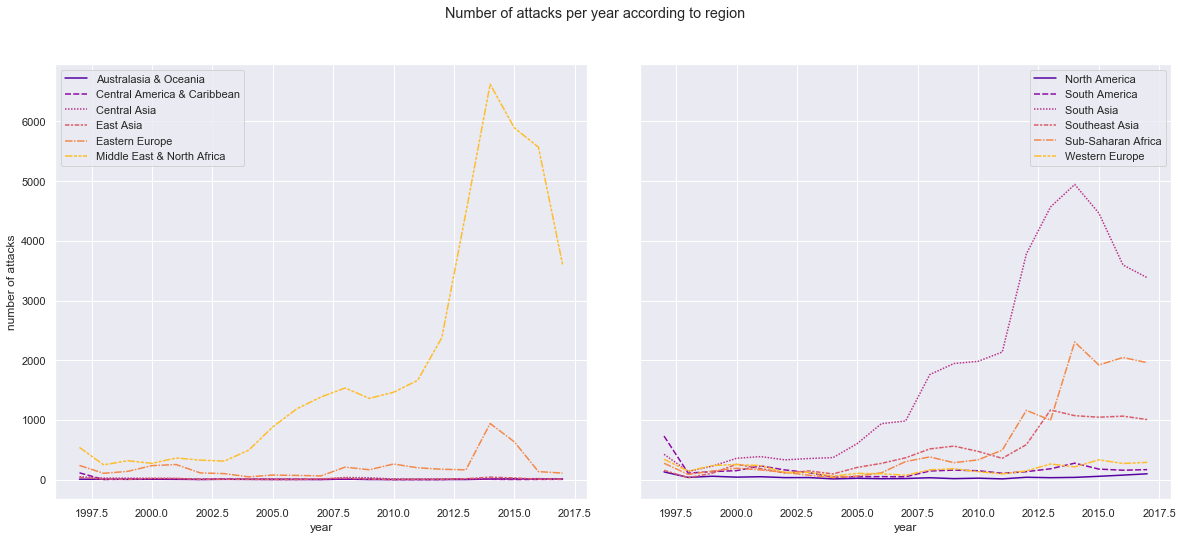

In [63]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,8), sharey=True)
fig.suptitle('Number of attacks per year according to region')
plt.gcf().subplots_adjust(wspace = 0.1)

sns.lineplot(data=df1,palette='plasma', ax= ax1)
ax1.set(xlabel='year', ylabel='number of attacks')

sns.lineplot(data=df2, palette='plasma', ax= ax2)
ax2.set(xlabel='year')

In [64]:
df_temp=df_approx
df_temp=df_temp.groupby(['year','region_txt']).agg({'nkillvi': 'sum'})

# Unsstack the outer index
dfa = df_temp.unstack(level=1)
dfa.columns = dfa.columns.droplevel()
df1 = dfa[dfa.columns[range(6)]]
df2= dfa.iloc[:,-6:]

[Text(0.5, 0, 'year')]

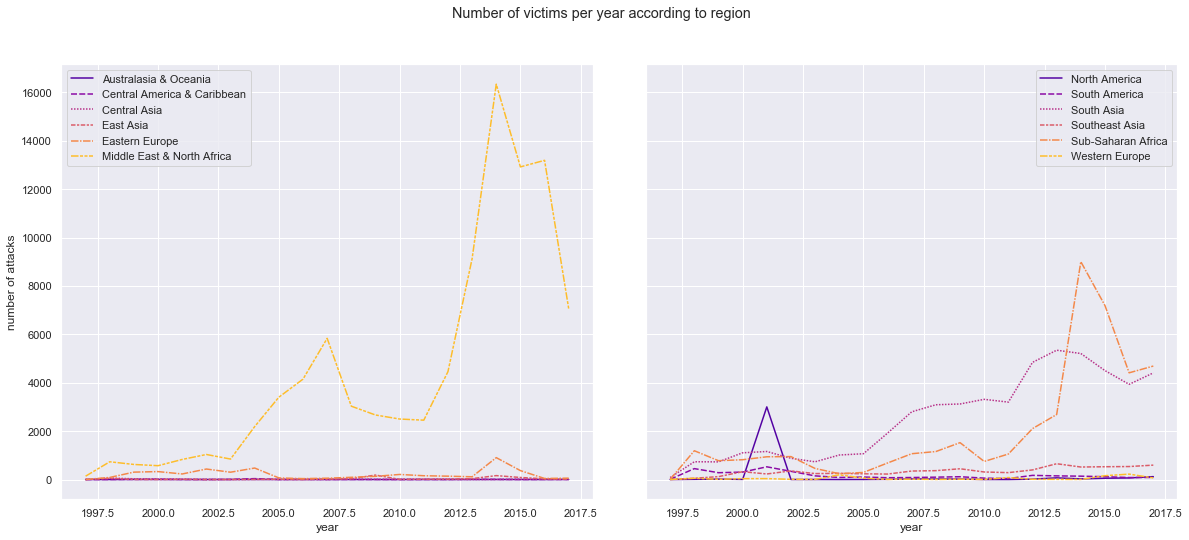

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (20,8), sharey=True)
fig.suptitle('Number of victims per year according to region')
plt.gcf().subplots_adjust(wspace = 0.1)

sns.lineplot(data=df1,palette='plasma', ax= ax1)
ax1.set(xlabel='year', ylabel='number of attacks')

sns.lineplot(data=df2, palette='plasma', ax= ax2)
ax2.set(xlabel='year')


### Getting an overall idea as to numbers of casualties in the past 50 years per region

In [66]:
df_temp2=df_approx
df_temp2.groupby('region_txt')['nkillvi'].agg('sum').sort_values(ascending = False)

region_txt
Middle East & North Africa     94085.0
South Asia                     53179.0
Sub-Saharan Africa             41985.0
Southeast Asia                  7042.0
Eastern Europe                  4544.0
South America                   3472.0
North America                   3463.0
Western Europe                   997.0
East Asia                        663.0
Central Asia                     233.0
Central America & Caribbean      100.0
Australasia & Oceania             12.0
Name: nkillvi, dtype: float64

Middle East and North Africa, South Asia and Sub-sahran Africa clearly deplore more deaths than other regions of the world. 

On the other hand, Australasia and Oceania recorded only 14 deaths. Is there significantly less deaths in Oceania ? We can see that, indeed the curve of that area is really flat compared to other regions on the graphs above.

Central Asia or Central America refer relatively few deaths as rather considered dangerous areas of the globe. It can be explained because the different events in these areas will be considered as conflicts due to wars or guerrilla rather than as terrorist attacks.

# Applied data analysis: Global Terrorism Maps

### Order and import dataframes

In [31]:
# load full dataframe
df_approx_completed = pd.read_csv('data/df_approx_completed.csv', encoding='ISO-8859-1', low_memory=False)
df_approx_completed.dropna(axis=0, subset=['country_txt'], inplace=True)
df_approx_completed.replace(-99.0, np.nan,inplace=True)

In [32]:
# select columsn of interest, we will only keep data from 1997 to 2017
df_map = df_approx_completed[['eventid', 'year', 'month', 'day', 'country_txt', 'city', 'longitude', 'latitude', 'attacktype1_txt', 
                        'weaptype1_txt', 'targtype1_txt', 'nkill', 'nkillter', 'nwound', 'nwoundte', 'propvalue']]
df_map = df_map[df_map['year'] > 1996]
# be sure to add all the geographical data with the country codes and everything
gdf = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
gdf=gdf[['name','geometry', 'iso_a3']].rename(columns={'name':'country_txt', 'iso_a3':'code'})
# change some of the name formats to make them match GTD
gdf=gdf.replace({'Bosnia and Herz.':'Bosnia-Herzegovina',
               'Central African Rep.':'Central African Republic',
               'Czechia':'Czech Republic', 
               'Dem. Rep. Congo':'Democratic Republic of the Congo',
               'Dominican Rep.':'Dominican Republic',
               'Eq. Guinea':'Equatorial Guinea',
               'Ivory Coast':"Côte d'Ivoire", 
               'Solomon Is.':'Solomon Islands',
               'United States of America':'United States',
               'W. Sahara':'Western Sahara'
              })

In [33]:
# merge by countries and keep the event counts and compute the true number of victims (minus the perpetrators)
df_time = df_map.groupby(['country_txt', 'year']).sum().reset_index()
df_time = df_time[['country_txt', 'year', 'nkill', 'nkillter', 'nwound', 'nwoundte', 'propvalue']]
df_time['nkilledvictims'] = df_time['nkill']-df_time['nkillter']
df_time['nwoundedvictims'] = df_time['nwound']-df_time['nwoundte']
df_time['ncasualties'] = df_time['nkilledvictims']+df_time['nwoundedvictims']
df_time['propvalue']=df_time['propvalue'].apply(lambda x: int(x)* np.sign(x))
df_time = pd.merge(df_time, df_map.groupby(['country_txt', 'year']).count() \
                   .reset_index()[['country_txt', 'eventid', 'year']], on=['country_txt', 'year'])

### Global terrorism interactive map with time slider

In [34]:
x = [str(x) for x in list(range(0, 8000, 1000))]
x.append('8000 +')

In [35]:
data_slider = []

merged_data = df_time

for year in merged_data['year'].unique():
    df_year = gdf.merge(df_time[df_time['year']==year], left_on="country_txt", right_on="country_txt", how="left")
    # keep all strings as plotly seems to handle them better
    for col in df_year.columns: 
        df_year[col] = df_year[col].astype(str)
    
    # text to put into the annotations
    df_year['text'] = "<b>"+df_year['country_txt']+"</b><br><br>"+ \
                        "<b>Number of casualties: "+df_year['ncasualties'].str.rstrip('.0')+"</b><br>"+ \
                        "Number of fatalities: "+df_year['nkilledvictims'].str.rstrip('.0')+"<br>"+ \
                        "Number of wounded: "+df_year['nwoundedvictims'].str.rstrip('.0')+"<br><br>"+ \
                        "Number of terror attacks: "+df_year['eventid'].str.rstrip('.0')+"<br>"+ \
                        "Cost of property damage in USD: "+df_year['propvalue']+"<br>"
    
    # create the dictionary with the data for the current year
    data_one_year = dict(
                        type ='choropleth',
                        locations = df_year['country_txt'],
                        z = df_year['ncasualties'],
                        locationmode ="country names",
                        colorscale = 'YlOrRd',
                        autocolorscale = False,
                        showscale = True,
                        text = df_year['text'],
                        hoverinfo ='text',
                        colorbar=dict(
                            title="Number of casualties",
                            titleside="top",
                            tickmode="array",
                            tickvals=list(range(0, 9000, 1000)),
                            ticktext=x,
                            ticks="outside"),
                        zmin = 0,
                        zmax = 8000,
                        marker_line_color='#6A6969',
                        marker_line_width=0.5
                        )
    

    data_slider.append(data_one_year)


In [36]:
steps = []

for i in range(len(data_slider)):
    step = dict(method='restyle',
                args=['visible', [False] * len(data_slider)],
                label='Year {}'.format(i + 1997),
               )
    step['args'][1][i] = True
    steps.append(step)

sliders = [dict(active=0, pad={"t": 0, "b": 0, "r": 0, "l": 0}, 
                steps=steps, transition={'duration': 300, 'easing': 'cubic-in-out'}, 
                yanchor='top', xanchor='left', 
                currentvalue={'font': {'size': 16},
                'visible': True,
                'xanchor': 'left'
    })]  
layout = dict(title_text='Global Terrorism between 1997 and 2017',
              height=800,
              hoverlabel= dict(
                bgcolor= 'white'
              ),
              geo=dict(scope='world', projection={'type': 'equirectangular'}, landcolor='#C4C4C4', showframe=False, showcoastlines=False),
              sliders=sliders)

fig = go.Figure(data=data_slider, layout=layout)

fig.show()
plotly.offline.plot(fig, filename = '../plots/TerrorismPlot.html', auto_open=False)

'../plots/TerrorismPlot.html'

## What about type of attacks and groups who claimed it ?

##### Expanding the claims into separate rows

It may be interesting to examine the different groups that claim attacks. To do this, we split the columns "gname" containing the list of these groups for each attack (some events have been claimed by several groups) in different lines and consider them individually. A large part of attacks have not been claimed by any groups, for further analysis, we will consider only the attacks which have been claimed by a group.

In [71]:
df_gname = df[['gname', 'year','targtype1_txt', 'weaptype1_txt', 'targsubtype1_txt','targsubtype1']]

#Separate groups' name (gname) list in individual rows
df_gname = df_gname.gname.apply(pd.Series).merge(df_gname, right_index = True, left_index = True) \
            .drop(["gname"], axis = 1) \
            .melt(id_vars = ['year','targtype1_txt','weaptype1_txt', 'targsubtype1_txt','targsubtype1'], value_name = "gname") \
            .drop("variable", axis = 1).dropna(subset = ['gname'])

In [76]:
# Select 30 most active groups
df_gname_top = df_gname[['gname', 'year']]
df_gname_top = df_gname_top.groupby('gname').count()
df_gname_top = df_gname_top.rename(columns={'year': 'count'}).sort_values(by='count', ascending = False)
df_gname_top['gname'] = df_gname_top.index
df_gname_top = df_gname_top[1:30][['count','gname']]
df_gname_top.gname=df_gname_top.gname.str.strip('[]').str.strip("''")
df_gname_top.head()

count  \
gname                                                       
['Taliban']                                          7238   
['Islamic State of Iraq and the Levant (ISIL)']      5153   
['Shining Path (SL)']                                4405   
['Al-Shabaab']                                       3246   
['Farabundo Marti National Liberation Front (FM...   3074   

                                                                                               gname  
gname                                                                                                 
['Taliban']                                                                                  Taliban  
['Islamic State of Iraq and the Levant (ISIL)']          Islamic State of Iraq and the Levant (ISIL)  
['Shining Path (SL)']                                                              Shining Path (SL)  
['Al-Shabaab']                                                                            Al-Shabaab  
['Farabundo Marti National Liberation Front (FM...  Farabundo Marti National Liberation Front (FMLN)

In [77]:
# Plot
df_gname_top.rename(columns={'gname' : 'group'}, inplace = True)

fig = px.bar(df_gname_top, x='group', y='count', height=800,
              title='Stacked Bar Chart - Hover on individual items')

fig.update_layout(
    title_text='Most active groups of terrorists',
    xaxis_title_text='Group who claimed the attacks', 
    yaxis_title_text='Number of attacks', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/MostActiveGroups.html', auto_open=False)

'../plots/MostActiveGroups.html'

Here we observe the most active terrorist groups in the last 50 years. It would be wise to explore what kind of population was targeted, throught what kind of weapon they are acting...

In [108]:
df_gname.gname=df_gname.gname.str.strip('[]').str.strip("''")
# Split list of weapons per attackant groups
df_gname_wep = df_gname.loc[df_gname.gname.isin(df_gname_top.group.values)]

df_gname_wep = df_gname_wep.weaptype1_txt.apply(pd.Series).merge(df_gname, right_index = True, left_index = True) \
            .drop(["weaptype1_txt"], axis = 1) \
            .melt(id_vars = ['targtype1_txt', 'year', 'gname', 'targsubtype1_txt','targsubtype1'], value_name = "weaptype1_txt") \
            .drop("variable", axis = 1).dropna(subset = ['weaptype1_txt'])

# For clarity
df_gname_wep.weaptype1_txt.loc[df_gname_wep.weaptype1_txt == \
                 'Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)'] = 'Vehicle'

In [111]:
# Count weapons per attackants
df_gname_wep_count = df_gname_wep.groupby(['gname', 'weaptype1_txt']).count() \
                                    .drop(columns =['targtype1_txt', 'targsubtype1_txt','targsubtype1']) \
                                    .rename(columns={'year' : 'count'})

# All unique weapons existing
weapons = df_gname_wep['weaptype1_txt'].unique()

# Fill unused weapons of groups with 0 in count for plotting 
for group, data in df_gname_wep_count.groupby(level=('gname')) :
    current_weapon = []
    
    for weapon in data.index :
        current_weapon.append(weapon[1])
    
    # if a weapon does not exist yet for the current group put count at 0
    for w in weapons :
        if w not in current_weapon :
            df_gname_wep_count.at[(group, w), 'count'] = 0
            
# Count 0 putr at the end of the dataframe -> reshape for clarity
df_gname_wep_count.reset_index(inplace = True)
df_gname_wep_count = df_gname_wep_count.groupby(['gname', 'weaptype1_txt']).agg('sum')
df_gname_wep_count.head()

count
gname                       weaptype1_txt       
"Donetsk People's Republic" Biological       0.0
                            Chemical         0.0
                            Explosives     368.0
                            Fake Weapons     0.0
                            Firearms       225.0

In [113]:
# Unique groups and weapons
x_uni=df_gname_top.group
y_uni=df_gname_wep['weaptype1_txt'].unique()

# Plot
traces = []
for weapon in y_uni :
    counts = []
    for group in x_uni :
        counts.append(df_gname_wep_count.loc[group,weapon].values[0])
    trace=go.Bar(name=weapon, x=x_uni, y=counts, visible=True)
    traces.append(trace)
fig = go.Figure(data=traces)

# Change the bar mode
fig.update_layout(barmode='stack',height=800,
    title_text='Weapon type used by most active groups of terrorists',
    xaxis_title_text='Attackant groups', 
    yaxis_title_text='Number of attacks', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/MostActiveGroupsWeapons.html', auto_open=False)

'../plots/MostActiveGroupsWeapons.html'

Now we will look more precisely according to the regions of the world, which groups are the most active.

In [128]:
df_approx_completed = pd.read_csv( '../../data/df_approx_completed.csv', encoding='ISO-8859-1' )

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning:

Columns (5,7,68,78) have mixed types. Specify dtype option on import or set low_memory=False.



In [129]:
#storing the dataframe in df_gname and making a selection to only have teror attacks ocurring after 1996
df_gname=df_approx_completed.loc[(df_approx_completed.gname != "['Unknown']")]
df_gname=df_gname.loc[(df_gname.year>1996)]

In [130]:
#function to extract countries from a list of text
def extract_countries(liste) :
    countries = []
    flag = False
    for country in pycountry.countries:
        if country.name in liste and flag == False:
            flag = True
            countries.append(country.name)     
    return countries

#function to extract cities from a list of text
def extract_cities(liste):
    cities = []
    places = GeoText(str(liste))
    places.cities
    if len(places.cities)>0:
        cities= places.cities       
    return cities

In [131]:
#only keeping the entries where a country is specified
df_gname=df_gname.loc[(df_gname.country_txt.notnull())]
df_gname=df_gname.reset_index(drop='index')

#storing this dataframe as a pickle file
df_gname.to_pickle("../../data/df_gname.pkl")

In [132]:
df_gname = pd.read_pickle('../../data/df_gname.pkl')

In [133]:
#modifying the countries to be sure that they have expected format to link the countries with continents
df_gname.country_txt=df_gname.country_txt.astype(str)
df_gname.country_txt=df_gname.country_txt.replace(regex={'Syria':'Syrian Arab Republic','Iran': 'Iran, Islamic Republic Of', 'South Korea': 'Korea, Republic Of','North Korea': "Korea, Democratic People'S Republic Of",\
                     'the United States': 'United States', 'US': 'United States','USA': 'United States', 'America': 'United States','United States of America': 'United States','U. S.':'United States',\
                    'Bosnia-Herzegovina':'Bosnia and Herzegovina','Kosovo':'Serbia','Serbia-Montenegro':'Serbia','Palestine':'Palestine, State of',\
                    'West Bank and Gaza Strip':'Palestine, State of', 'Yugoslavia':'Bosnia and Herzegovina','Zaire':'Republic of the Congo', 'Vietnam': 'Viet Nam'})    
df_gname['country_txt'] = df_gname.country_txt.apply(lambda x: list(set(extract_countries(x))))
df_gname.country_txt=df_gname.country_txt.astype(str)
df_gname.country_txt=df_gname.country_txt.str.strip('[]').str.strip("'")

In [136]:
#creating a new tag according to continent
import pycountry_convert as pc
Continent = []
df_gname.country_txt=df_gname.country_txt.astype(str)
for index, row in tqdm(df_gname.iterrows()):
    if(row['country_txt']!='nan' and  row['country_txt']!='' ):
      
        country_code = pc.country_name_to_country_alpha2(df_gname.country_txt[index], cn_name_format="default")
        #print(country_code)
        if (country_code=='AQ'):
            Continent.append('AQ')
        else:
            continent_name = pc.country_alpha2_to_continent_code(country_code)
            Continent.append(continent_name)
    else:
        Continent.append('Nan')
       # print(country_code)
#stocking this information in a new column continent
df_gname['continent']=Continent    

#storing this dataframe as a pickle file
df_gname.to_pickle("../../data/df_continents.pkl")

54813it [00:09, 5853.88it/s]


In [137]:
df_gname = pd.read_pickle('../../data/df_gname_continents.pkl')

In [138]:
df_revend_cont=df_gname.continent.value_counts().to_frame()
df_revend_cont.index=df_revend_cont.index.astype(str)
df_revend_cont=df_revend_cont.reset_index().rename(columns={'continent':'count','index':'continent'})
df_revend_cont.continent=df_revend_cont.continent.replace(regex={'AS':'Asia','AF': 'Africa', 'EU': 'Europe','SA':'South America','NA':'North America','OC': 'Oceania'})

In [139]:
df_revend_cont


continent  count
0           Asia  35957
1         Africa  12186
2         Europe   2823
3  South America   2532
4            Nan    745
5  North America    544
6        Oceania     26

Through this dataframe, we can see that the number of claimed terror attacks over the various continents

In [140]:
#reformating the names of the groups 
df_gname.gname=df_gname.gname.str.strip('[]').str.strip("''").str.strip('""')

#grouping by groups according to the continents and counting the number of attacks
df_continent=df_gname.groupby(['continent'])['gname'].value_counts().to_frame()
df_continent['attack counts']=df_gname.groupby(['continent'])['gname'].value_counts()
df_continent=df_continent.drop(columns='gname')

#creating a ratio for potential comparison of the magnitude of the groups activity
df_continent['ratio']=df_continent['attack counts']/df_continent['attack counts'].sum()

In [141]:
#preparation of the test dataset which is selectioned according to rank to allow plotting
df_test=df_continent.reset_index()
df_test['rank']=df_test.groupby('continent')['attack counts'].rank(ascending=False)

#now that the ranks have been created, can transform the attack counts to string
df_continent['attack counts']=df_continent['attack counts'].astype(str)


In [142]:
# Python program to generate WordCloud 
from PIL import Image
import os
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 

#importations to modify the colors of the wordclouds
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(50, 90%%, %d%%)" % random.randint(30, 100)

#importation of plotly to make interactive graphs
import plotly.graph_objects as go

In [143]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='AF']['rank'], y=df_test[df_test.continent=='AF']['attack counts'],
                    mode='lines',
                    name='Africa'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='AS']['rank'], y=df_test[df_test.continent=='AS']['attack counts'],
                    mode='lines',
                    name='Asia'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='SA']['rank'], y=df_test[df_test.continent=='SA']['attack counts'],
                    mode='lines',
                    name='South America'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='NA']['rank'], y=df_test[df_test.continent=='NA']['attack counts'],
                    mode='lines',
                    name='North America'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='EU']['rank'], y=df_test[df_test.continent=='EU']['attack counts'],
                    mode='lines',
                    name='Europe'))
fig.update_layout(
    #xaxis_type="log",
    title_text='Distribution of number of attacks of 100 most active groups ',
    xaxis_title_text='100 top groups', 
    yaxis_title_text='active counts', 
    bargroupgap=0.1
)

In [146]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='AF']['rank'][0:100], y=df_test[df_test.continent=='AF']['attack counts'],
                    mode='lines',
                    name='Africa'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='AS']['rank'][0:100], y=df_test[df_test.continent=='AS']['attack counts'],
                    mode='lines',
                    name='Asia'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='SA']['rank'][0:100], y=df_test[df_test.continent=='SA']['attack counts'],
                    mode='lines',
                    name='South America'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='NA']['rank'][0:100], y=df_test[df_test.continent=='NA']['attack counts'],
                    mode='lines',
                    name='North America'))
fig.add_trace(go.Scatter(x=df_test[df_test.continent=='EU']['rank'][0:100], y=df_test[df_test.continent=='EU']['attack counts'],
                    mode='lines',
                    name='Europe'))
fig.update_layout(
    xaxis_type="log",
    title_text='Distribution of number of attacks of 100 most active groups ',
    xaxis_title_text='100 most active groups', 
    yaxis_title_text='number of attacks', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/100mostactive_continent.html', auto_open=False)

'../plots/100mostactive_continent.html'

We have seen that there is a large difference in numbers of attacks per continent, but how does this translate to the different terrorist groups around the world? Which groups are active where, and how many "terrorist" groups claim their attacks within the various continents?
According to the plot above, we can see that the distribution of activity of the groups follows a power law. The most active groups, especially in asia, are extremely active. This puts the magnitude of the most active groups into perspective. In Asia, the most active groups have attacked over 7000 times, while in North america, the "most active" terrorist group attacked around 50 times. 

### if we look at the active groups according to continent symbolicaly

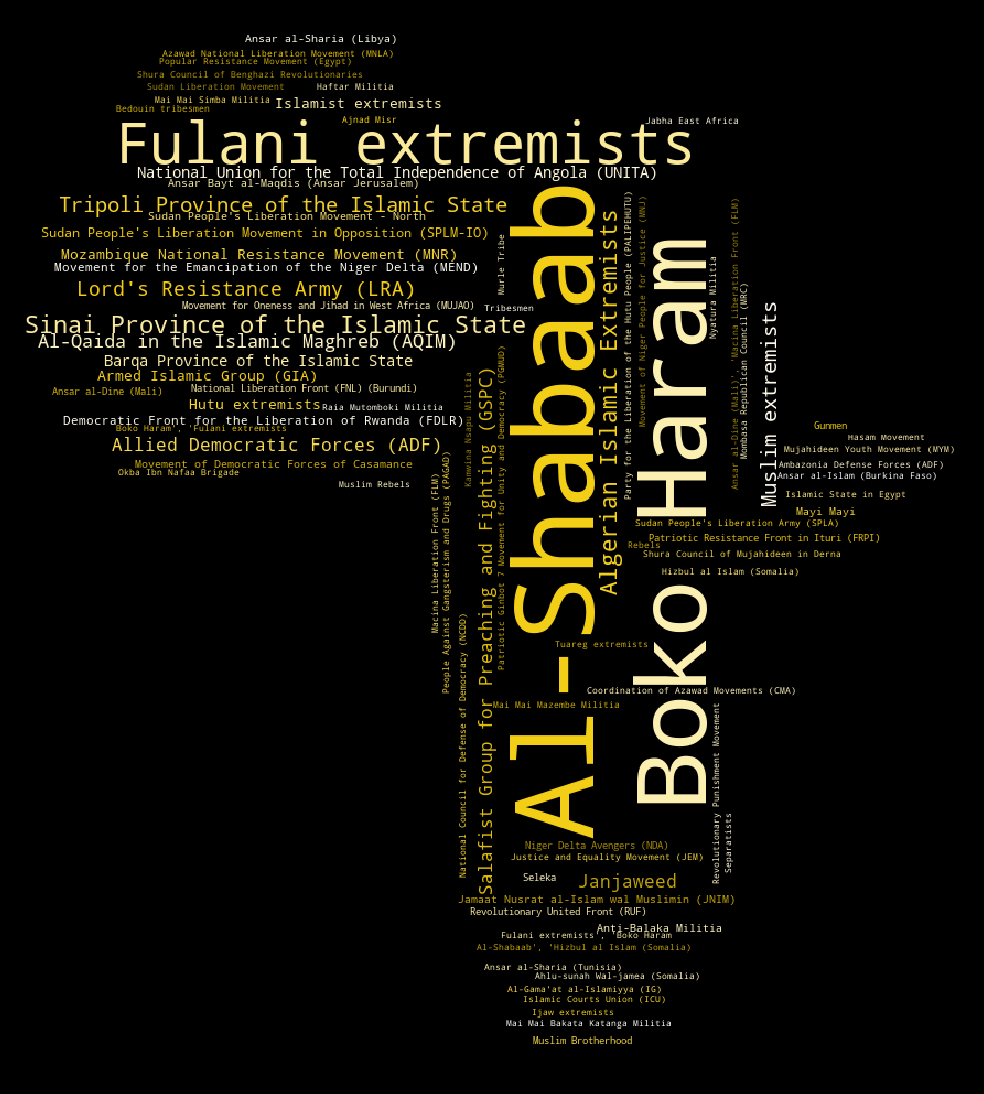

In [147]:
#creating a word cloud of the main themes 
subset=df_continent.loc['AF'].sort_values(by='ratio', ascending=False)
text=subset['ratio']

mask=np.array(Image.open("../../data/africa.png"))
wordcloud = WordCloud(#width = 6000, height = 3000, 
                background_color ='black', 
                mask=mask,
                min_font_size=5,
                max_font_size= 100,
                #max_words = 100,
                ).generate_from_frequencies(text) 

#change the color setting
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                        
plt.figure(figsize = (15, 15), facecolor = 'black') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
#plt.savefig('../../data/article_themes_wordmap.png')
  
plt.show() 
plt.savefig('../plots/northamerica_groups.png')

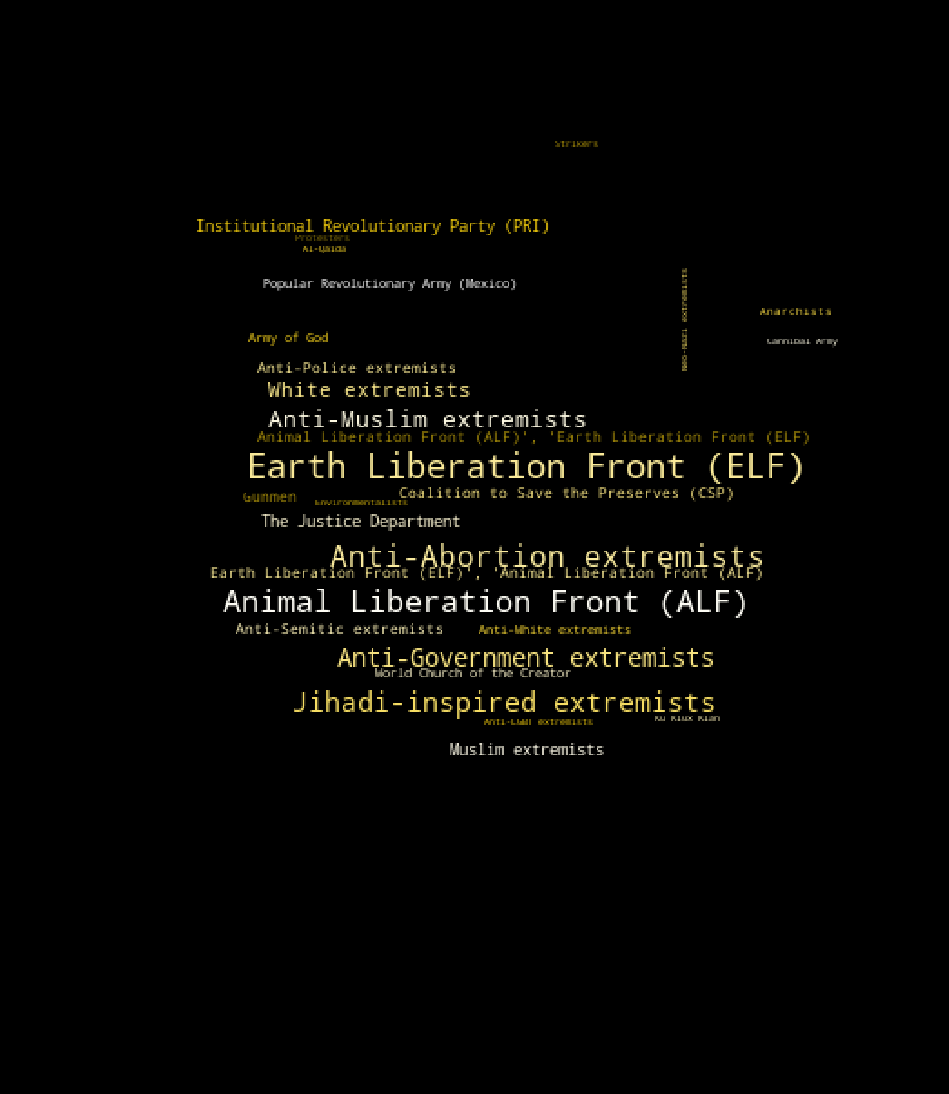

In [148]:
#creating a word cloud of the main themes 
subset=df_continent.loc['NA'].sort_values(by='ratio', ascending=False)
text=subset['ratio']

mask=np.array(Image.open("../../data/North_america.png"))
wordcloud = WordCloud(#width = 6000, height = 3000, 
                background_color ='black', 
                mask=mask,
                min_font_size=5,
                max_font_size= 100,
                #max_words = 100,
                ).generate_from_frequencies(text) 

#change the color setting
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                        
plt.figure(figsize = (15, 15), facecolor = 'black') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
#plt.savefig('../../data/article_themes_wordmap.png')
  
plt.show() 
plt.savefig('../plots/northamerica_groups.png')

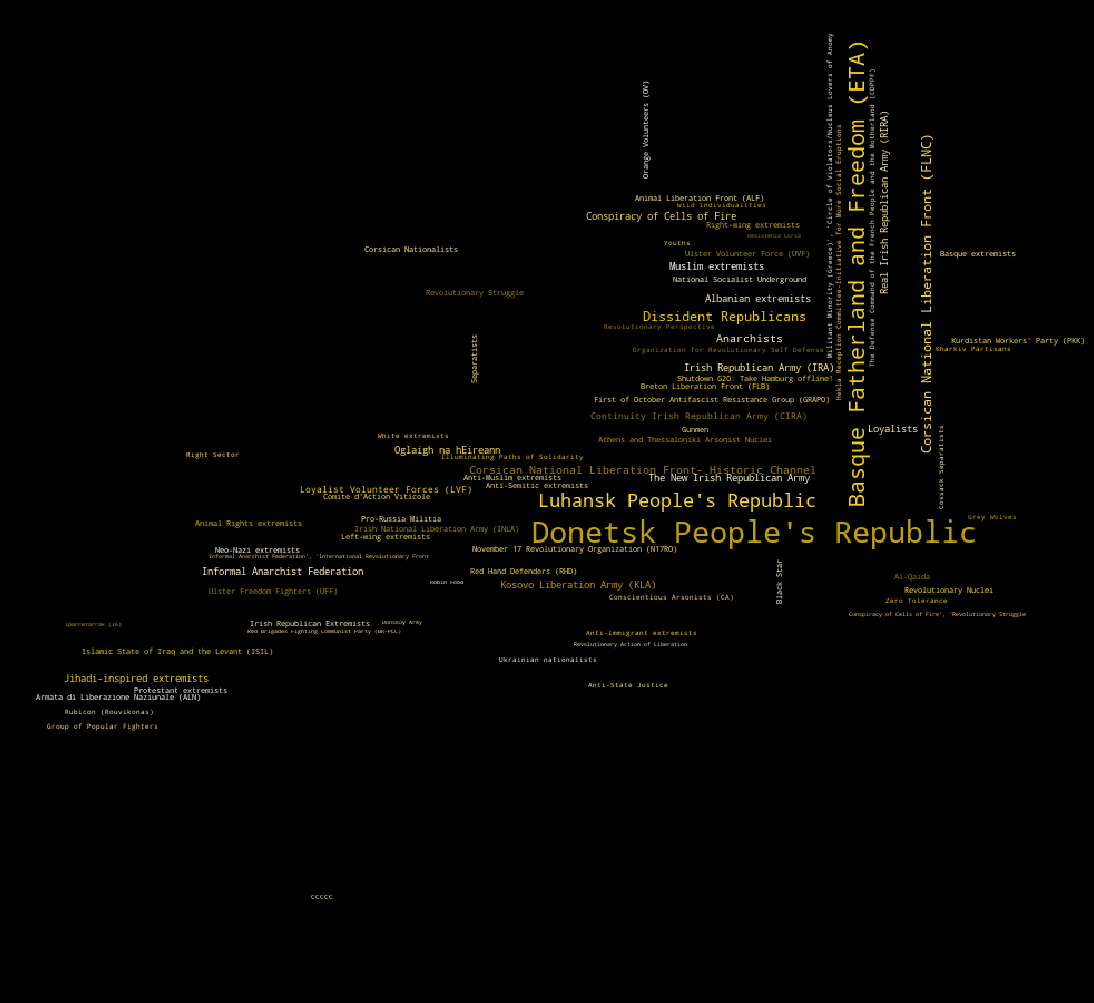

In [149]:
#creating a word cloud of the main themes 
subset=df_continent.loc['EU'].sort_values(by='ratio', ascending=False)
text=subset['ratio']

mask=np.array(Image.open("../../data/Europe.jpg"))
wordcloud = WordCloud(#width = 6000, height = 3000, 
                background_color ='black', 
                mask=mask,
                min_font_size=5,
                max_font_size= 100,
                #max_words = 100,
                ).generate_from_frequencies(text) 

#change the color setting
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                        
plt.figure(figsize = (15, 15), facecolor = 'black') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
#plt.savefig('../../data/article_themes_wordmap.png')
  
plt.show() 
plt.savefig('../plots/europe_groups.png')

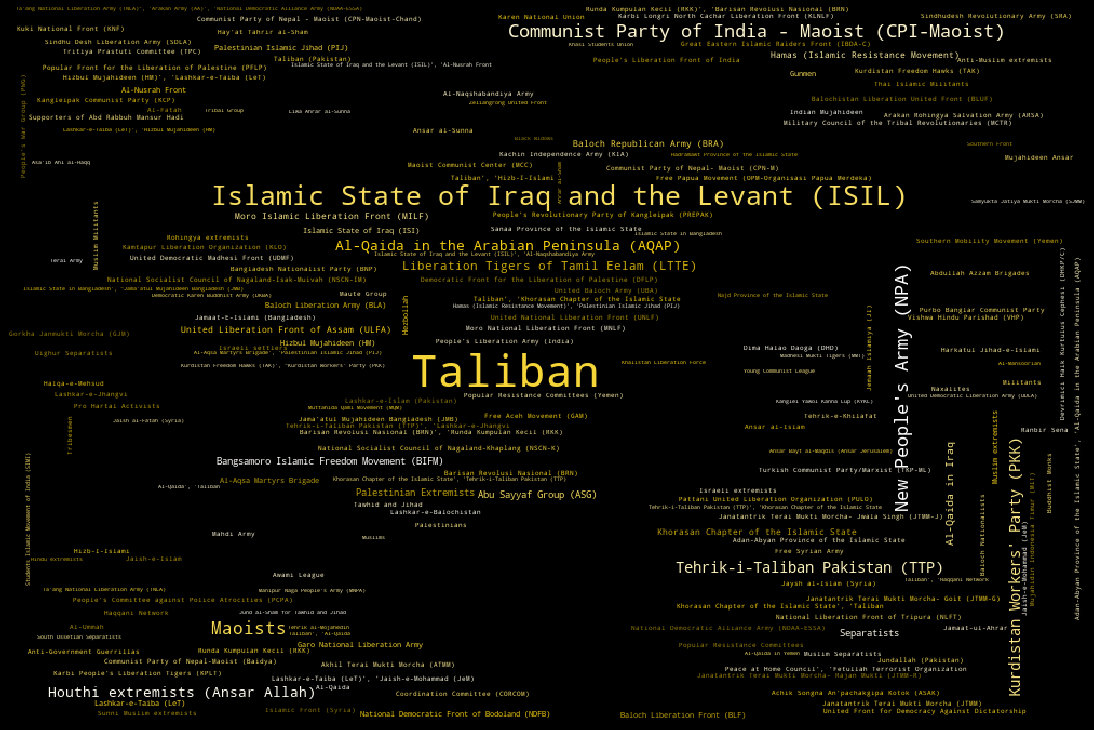

<Figure size 432x288 with 0 Axes>

In [150]:
#creating a word cloud of the main themes 
subset=df_continent.loc['AS'].sort_values(by='ratio', ascending=False)
text=subset['ratio']

mask=np.array(Image.open("../../data/asia_1.png"))
wordcloud = WordCloud(#width = 6000, height = 3000, 
                background_color ='black', 
                mask=mask,
                #min_font_size=5,
                #max_font_size= 100,
                #max_words = 100,
                ).generate_from_frequencies(text)#*df_continent_gname.loc['AS']['gname'].count()) 

#change the color setting
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                        
plt.figure(figsize = (15, 15), facecolor = 'black') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
#plt.savefig('../../data/article_themes_wordmap.png')
  
plt.show() 
plt.savefig('../plots/asia_groups.png')

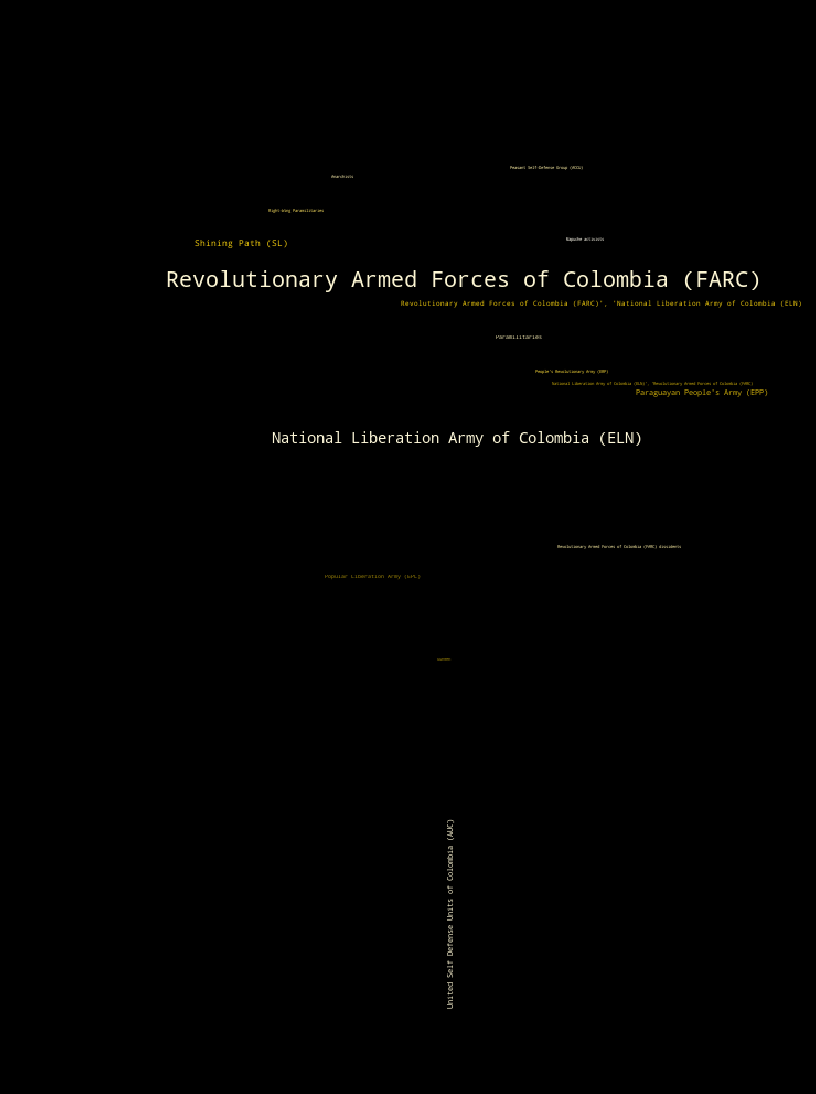

In [151]:
#creating a word cloud of the main themes 
subset=df_continent.loc['SA'].sort_values(by='ratio', ascending=False)
text=subset['ratio']

mask=np.array(Image.open("../../data/southamerica_1.jpg"))
wordcloud = WordCloud(#width = 6000, height = 3000, 
                background_color ='black', 
                mask=mask,
                #min_font_size=5,
                max_font_size= 100,
                #max_words = 100,
                ).generate_from_frequencies(text) 

#change the color setting
wordcloud.recolor(color_func = grey_color_func)
# plot the WordCloud image                        
plt.figure(figsize = (15, 15), facecolor = 'black') 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('../../data/article_themes_wordmap.png')
  
plt.show() 


According to the graphs above, we can see which groups are active proportionately to one another within the continent, but can not directly be compared between the different continents, as was shown in the line plot expliciting the magnitude difference of active groups between continents.

Most of attacks use explosive or firearms. We will now look into linking those type of attacks with the amount of casualties. 

# Groups and Target types

In [117]:
# Split targets types per attackants groups
df_gname_target = df_gname.loc[df_gname.gname.isin(df_gname_top.group.values)]

df_gname_target = df_gname_target.targtype1_txt.apply(pd.Series).merge(df_gname_target, right_index = True, left_index = True) \
            .drop(["targtype1_txt", ], axis = 1) \
            .melt(id_vars = ['weaptype1_txt', 'year', 'gname','targsubtype1_txt','targsubtype1'], value_name = "targtype1_txt") \
            .drop("variable", axis = 1).dropna(subset = ['targtype1_txt'])


In [118]:
# Count target per groups
df_gname_target_count = df_gname_target.groupby(['gname', 'targtype1_txt']).count() \
                                    .drop(columns =['weaptype1_txt','targsubtype1_txt','targsubtype1']) \
                                    .rename(columns={'year' : 'count'})

# Unique targets in the dataframe
targets = df_gname_target['targtype1_txt'].unique()

# Fill un-targetted of groups with 0 in count for plotting 
for group, data in df_gname_target_count.groupby(level=('gname')) :
    current_targets = []
    
    for target in data.index :
        current_targets.append(target[1])
        
    # if a target does not exist yet for the current group put count at 0
    for t in targets :
        if t not in current_targets :
            df_gname_target_count.at[(group, t), 'count'] = 0
            
# Counts that are 0 are at the end of the data frame, reshape to organize
df_gname_target_count.reset_index(inplace = True)
df_gname_target_count = df_gname_target_count.groupby(['gname', 'targtype1_txt']).agg('sum')
df_gname_target_count.head()

count
gname                       targtype1_txt                 
"Donetsk People's Republic" Airports & Aircraft        2.0
                            Business                  20.0
                            Educational Institution    5.0
                            Food or Water Supply       2.0
                            Government (Diplomatic)   10.0

In [120]:
# Unique groups and targets
x_uni=df_gname_top.group
y_uni=df_gname_target['targtype1_txt'].unique()

# Plot
traces_target = []
for target in y_uni :
    counts = []
    for group in x_uni :
        counts.append(df_gname_target_count.loc[group, target].values[0])
    trace=go.Bar(name=target, x=x_uni, y=counts, visible=True)
    traces_target.append(trace)
fig = go.Figure(data=traces_target)

# Change the bar mode
fig.update_layout(barmode='stack',height=800,
    title_text='Proportion of victims targeted by the most active groups of terrorists',
    xaxis_title_text='Attacking groups', 
    yaxis_title_text='Number of attacks', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/MostActiveTarget.html', auto_open=False)

'../plots/MostActiveTarget.html'

The most common target types over all the different active groups is generally linked with government and some of its components as police, military and some individual private citizens. 

### Subtargets

Targets and subtargets have been merged in lists for each attack, the following numbers are retreived from https://www.start.umd.edu/gtd/downloads/Codebook.pdf to reconnect targets with associated sub targets

In [122]:
police = list(range(22,27))
buisness = list(range(1,14))
buisness.append(113)
government_general = list(range(14, 22))
military = list(range(27, 38))
military.append(39)
abortion_related = list(range(40,42))
airports_and_aircraft = list(range(42,45))
government_diplomatic = list(range(45,48))
education_institution = list(range(48,51))
food_and_water_supply = list(range(51,53))
journalists_media = list(range(53,57))
maritime = list(range(57,61))
ngo = list(range(61,63))
other = list(range(63,65))
other.append(66)
private_citizens_and_property = list(range(67,85))
private_citizens_and_property.extend([65,113])
religious_figures_or_institutions = list(range(85,88))
telecommunication = list(range(88,93))
terrorist_or_non_state_militia = list(range(93,95))
tourists = list(range(95,99))
transportation =list(range(99,106))
utilities = list(range(106,109))
violent_political_parties = list(range(109,112))

In [123]:
dictionnaire = {'Military' : military, 'Police' : police, 'Government (General)' : government_general, \
               'Private Citizens & Property' : private_citizens_and_property, 'Business' : buisness, \
               'Tourists' : tourists, 'NGO' : ngo, 'Transportation' : transportation, 'Utilities' : utilities, \
               'Terrorists/Non-State Militia' : terrorist_or_non_state_militia, \
                'Educational Institution': education_institution, 'Maritime' : maritime, \
                'Airports & Aircraft' : airports_and_aircraft, 'Journalists & Media': journalists_media, \
               'Government (Diplomatic)': government_diplomatic, 'Violent Political Party': violent_political_parties, \
               'Religious Figures/Institutions' : religious_figures_or_institutions, \
               'Food or Water Supply' : food_and_water_supply, 'Telecommunication' : telecommunication, \
               'Other' : other}

In [124]:
df_targets = df[['targtype1_txt', 'targsubtype1_txt','targsubtype1']]

#Separate targets list in individual rows
df_targets = df_targets.targtype1_txt.apply(pd.Series).merge(df_targets, right_index = True, left_index = True) \
            .drop(["targtype1_txt"], axis = 1) \
            .melt(id_vars = ['targsubtype1_txt','targsubtype1'], value_name = "targtype1_txt") \
            .drop("variable", axis = 1).dropna(subset = ['targtype1_txt'])
df_targets.head()

targsubtype1_txt targsubtype1  \
0                                   [Named Civilian]         [68]   
1  [Diplomatic Personnel (outside of embassy, con...         [45]   
2                  [Radio Journalist/Staff/Facility]         [54]   
3                                [Embassy/Consulate]         [46]   
4                                [Embassy/Consulate]         [46]   

                 targtype1_txt  
0  Private Citizens & Property  
1      Government (Diplomatic)  
2          Journalists & Media  
3      Government (Diplomatic)  
4      Government (Diplomatic)

In [125]:
# This funtion find the postition of the intersept of the code targsubtype1 with the above codes and retain codes 
# (targsubtype1) and the name (targsubtype1_txt) that intersept at the same positions to keep only subtypes 
# associated to the target
def retain_index(row):
    subtarget_txt = row['targsubtype1_txt']
    subtarget_num = row['targsubtype1']
    target = row['targtype1_txt']
    
    inter = set(subtarget_num).intersection(intersect)
    indices = [ subtarget_num.index(x) for x in inter ]
    res_list = [subtarget_txt[i] for i in indices] 
    
    return target, res_list, inter

In [126]:
# Take all targets type
list_target = y_uni.tolist()
list_target.remove('Unknown')

# To make the first frame visible in plotting
visible_first_frame = list(x == 'Military' for x in list_target )

# Initialize figure
fig = go.Figure()

# Initialize buttons
list_buttons = []

# Iterate across target to find subtarget and add respective graphs
for targ in list_target :
    # Define the intersection to find 
    intersect = dictionnaire[targ]
    df_current_targets = df_targets.loc[df_targets.targtype1_txt == targ]

    # Find the subtargets associated with the target
    df_current_targets['targtype1_txt'], df_current_targets['targsubtype1_txt'], \
                            df_current_targets['targsubtype1'] = zip(*df_current_targets.apply(retain_index, axis=1))

    #Separate subtargets list in individual rows
    df_current_targets = df_current_targets.targsubtype1_txt.apply(pd.Series) \
                .merge(df_current_targets, right_index = True, left_index = True) \
                .drop(["targsubtype1_txt"], axis = 1) \
                .melt(id_vars = ['targtype1_txt','targsubtype1'], value_name = "targsubtype1_txt") \
                .drop("variable", axis = 1).dropna(subset = ['targsubtype1_txt'])
    
    # Count sub targets
    df_current_targets_count = df_current_targets.groupby('targsubtype1_txt').count()
    df_current_targets_count = df_current_targets_count.rename(columns={'targsubtype1': 'count'})\
                                                        .sort_values(by='count', ascending = False)
    df_current_targets_count.drop(columns = ['targtype1_txt'], inplace = True)
    
    # Add frames and adapt buttons for plotting
    fig.add_trace(go.Bar(name=targ, 
    x=df_current_targets_count.index,
    y=df_current_targets_count['count'].values, visible= visible_first_frame[list_target.index(targ)]))
    
    list_buttons.append(dict(label= targ, 
                         method="update",
                         args=[{"visible": list(target == targ for target in list_target)},
                           {"title": targ}]))

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [127]:
# Plot
fig.update_layout(
    updatemenus=[
        go.layout.Updatemenu(
            buttons=list(list_buttons),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.37,
            xanchor="left",
            y=1.13,
            yanchor="top"
        )
    ],    
    height = 800,
    title_text="Sub Target types per Target",
    xaxis_title_text='Sub Targets', 
    yaxis_title_text='Number of attacks', 
    bargroupgap=0.1)

fig.show()
plotly.offline.plot(fig, filename = '../plots/SubTargets.html', auto_open=False)

'../plots/SubTargets.html'

# Linking Terrorism Database to Mediatic Coverage

### Quantitative article coverage analysis

Load the articles and drop columns that are non relevant

In [193]:
df_art = pd.read_pickle('../../data/df_continents.pkl')

In [194]:
df_art['date']=pd.to_datetime(df_art.date, exact=False, errors = 'coerce')
df_art['top_themes'] = df_art['top_themes'].apply(lambda x : ast.literal_eval(str(x)))
df_art['cities'] = df_art['cities'].apply(lambda x : ast.literal_eval(str(x)))

In [196]:
df_art=df_art.drop(columns=['aggression', 'anger', 'crime', 'death', 'economy', 'fear', 'fight', 'government', 'hate', 'horror',
                           'immigration', 'independence', 'kill', 'movement', 'politics', 'prison', 'religion', 'suffering', 'terrorism',
                            'violence', 'war', 'desc', 'continent', 'publication', 'top_themes', 'locations'])

In [197]:
def clean_title(x):
    # Some strings in the df_art are weirdly formatted and somehow start with a 'b' character that we just remove
    if str(x).startswith('b'):
        return str(x)[2:]
    else : return str(x)

df_art['title'] = df_art['title'].apply(clean_title)

In [202]:
# Use simple usual pre-processing on words to handle than later more easily
df_art['title'] = df_art['title'].apply(word_tokenize) \
    .apply(lambda x: [word for word in x if word not in (stop)]) \
    .apply(lambda x: [token for token in x if token not in string.punctuation]) \
    .apply(lambda x: [re.sub('[^a-zA-Z]+', '', s) for s in x]) \
    .apply(lambda x: list(filter(None, x)))

In [207]:
# loading tht global terrorism dataset
df_approx_ = pd.read_csv("../../data/df_approx_completed.csv")
df_approx_.dropna(axis=0, subset=['country_txt'], inplace=True)
df_approx_.replace(-99.0, np.nan,inplace=True)
df_approx_ = df_approx_[df_approx_['year'] > 1996]
df_approx_['date']=pd.to_datetime(df_approx_.date, exact=False, errors = 'coerce')

In [208]:
# Keep only columns of interest
df_approx_ = df_approx_[['eventid', 'year', 'month', 'day', 'date', 'country_txt', 'city', 
                       'region_txt', 'attacktype1_txt', 'targtype1_txt', 'targsubtype1_txt',
                       'claimmode_txt', 'weaptype1_txt', 'weapsubtype1_txt', 'nkill', 'nkillter',
                       'nwound', 'propvalue', 'nwoundte', 'related', 'summary']]

In [209]:
# Sometimes when importing data, some columns format shall be corrected
df_approx_['attacktype1_txt'] = df_approx_['attacktype1_txt'].apply(lambda x : ast.literal_eval(str(x)))
df_approx_['targtype1_txt'] = df_approx_['targtype1_txt'].apply(lambda x : ast.literal_eval(str(x)))
df_approx_['targsubtype1_txt'] = df_approx_['targsubtype1_txt'].apply(lambda x : ast.literal_eval(str(x)))
df_approx_['claimmode_txt'] = df_approx_['claimmode_txt'].apply(lambda x : ast.literal_eval(str(x)))
df_approx_['weaptype1_txt'] = df_approx_['weaptype1_txt'].apply(lambda x : ast.literal_eval(str(x)))
df_approx_['weapsubtype1_txt'] = df_approx_['weapsubtype1_txt'].apply(lambda x : ast.literal_eval(str(x)))

In [210]:
df_approx_['summary'].fillna('', inplace=True)

In [211]:
df_approx_['summary'] = df_approx_['summary'].apply(word_tokenize) \
    .apply(lambda x: [word for word in x if word not in (stop)]) \
    .apply(lambda x: [token for token in x if token not in string.punctuation]) \
    .apply(lambda x: [re.sub('[^a-zA-Z]+', '', s) for s in x]) \
    .apply(lambda x: list(filter(None, x)))

### Merge datasets

#### Merge related events in the Global Terrorism Database

First of all, we want to merge all related events in the Global Terrorism Database to avoid having duplicated articles about one attack. To do so, we will just recover the information in the `related` column and sum up the corresponding data in each column in ordter to not loose any information when merging. 
To keep a track at all events we would like to keep (and remove the related ones), we keep a list of events to also avoid duplicates.

In [212]:
def merge_related_events(row):
    
    rel=row['related']
    event=row['eventid']
    summary=row['summary']
    city=row['city']
    attacktype1_txt=row['attacktype1_txt']
    targtype1_txt=row['targtype1_txt']
    targsubtype1_txt=row['targsubtype1_txt']
    claimmode_txt=row['claimmode_txt']
    weaptype1_txt=row['weaptype1_txt']
    weapsubtype1_txt=row['weapsubtype1_txt']
    nkill=row['nkill']
    nkillter=row['nkillter']
    nwound=row['nwound']
    nwoundte=row['nwoundte']
    propvalue=row['propvalue']
    
    # case if there is no related event
    if event not in event_to_keep:
        if pd.isna(rel):
            event_to_keep.append(event)
        # if there are related events, find which ones    
        elif not pd.isna(rel):
            rel = re.findall("\d+", rel)
            rel = [float(x) for x in rel]
            # check that none of the other related events was already in the final dataframe
            overlap = list(set(event_to_keep).intersection(set(rel)))
            if len(overlap) == 0 : 
        
                rel_df = df_approx_[df_approx_['eventid'].isin(rel)]
            
                rel_sum = rel_df.summary.tolist()
                rel_sum = [item for elem in rel_sum for item in elem]
                summary = list(set(summary+rel_sum)) # keep uniqe words in the concatenated summary
                
                rel_city = rel_df.city.tolist()
                city = list([city]+rel_city)
                # keep most represented city in the list of related events
                vals, counts = np.unique(city, return_counts=True)
                order = np.argsort(counts)[::-1]
                city = np.repeat(vals[order], counts[order]).tolist()
                city = city[0]
                
                # as some features are lists of words, we append them up to have the complete set of features when merging
                rel_attacktype1_txt = rel_df.attacktype1_txt.tolist()
                rel_attacktype1_txt = [item for elem in rel_attacktype1_txt for item in elem]
                attacktype1_txt = list(set(attacktype1_txt+rel_attacktype1_txt))
                
                rel_targtype1_txt = rel_df.targtype1_txt.tolist()
                rel_targtype1_txt = [item for elem in rel_targtype1_txt for item in elem]
                targtype1_txt = list(set(targtype1_txt+rel_targtype1_txt))
                
                rel_targsubtype1_txt = rel_df.targsubtype1_txt.tolist()
                rel_targsubtype1_txt = [item for elem in rel_targsubtype1_txt for item in elem]
                targsubtype1_txt = list(set(targsubtype1_txt+rel_targsubtype1_txt))
                                     
                rel_claimmode_txt = rel_df.claimmode_txt.tolist()
                rel_claimmode_txt = [item for elem in rel_claimmode_txt for item in elem]
                claimmode_txt = list(set(claimmode_txt+rel_claimmode_txt))
                                     
                rel_weaptype1_txt = rel_df.weaptype1_txt.tolist()
                rel_weaptype1_txt = [item for elem in rel_weaptype1_txt for item in elem]
                weaptype1_txt = list(set(weaptype1_txt+rel_weaptype1_txt)) 
                                     
                rel_weapsubtype1_txt = rel_df.weapsubtype1_txt.tolist()
                rel_weapsubtype1_txt = [item for elem in rel_weapsubtype1_txt for item in elem]
                weapsubtype1_txt = list(set(weapsubtype1_txt+rel_weapsubtype1_txt))                     
                
                # sum up nkill, nkillter, nwound, nwoundte, propvalue when merging related events
                nkill += np.nansum(rel_df.nkill.tolist())
                nkillter += np.nansum(rel_df.nkillter.tolist())
                nwound += np.nansum(rel_df.nwound.tolist())      
                nwoundte += np.nansum(rel_df.nwoundte.tolist())          
                propvalue += np.nansum(rel_df.propvalue.tolist())
                
                # event_to_keep is a sanity check
                event_to_keep.append(event)
                
    return (summary, city, attacktype1_txt, targtype1_txt, targsubtype1_txt, claimmode_txt, 
            weaptype1_txt, weapsubtype1_txt, nkill, nkillter, nwound, nwoundte, propvalue)

In [213]:
event_to_keep = []

# merge related events
df_approx_['summary'], df_approx_['city'], df_approx_['attacktype1_txt'], df_approx_['targtype1_txt'], \
df_approx_['targsubtype1_txt'], df_approx_['claimmode_txt'], df_approx_['weaptype1_txt'], \
df_approx_['weapsubtype1_txt'], df_approx_['nkill'], df_approx_['nkillter'], df_approx_['nwound'], \
df_approx_['nwoundte'], df_approx_['propvalue'] = zip(*df_approx_.apply(merge_related_events, axis=1))

df_approx_ = df_approx_[df_approx_['eventid'].isin(event_to_keep)]

#### Find articles  about the terror attack

Let's define a time slot after the terror attack where to look for publications about this particular attack and keep the matching countries and cities. 

In [214]:
span = 6 #months

In [215]:
def select_article_from_event(row, df, span=6):
    # select data within a certain span in number of months after an event date, here we chose 6 months
    # df is the dataframe containing articles
    date = row['date']
    country = row['country_txt']
    city = row['city']

    n_df = df[(df['date'] > date) 
       & (df['date'] <= date + pd.offsets.DateOffset(months=span))]
    
    # select data located in a certain country
    n_df = n_df[(n_df['countries'] == country)]
    
    if not pd.isna(city) :
        # select data with precise city location
        city_df = n_df[n_df['cities'].apply(lambda x : len(set(x).intersection(set([city]))) > 0)]
        n_df = pd.concat([n_df, city_df]).drop_duplicates(subset =['word_counts','key_0']).reset_index(drop=True)
        
    # return the list of selected articles
    return n_df

Now that we have written nice functions to link articles to terror attacks based on publication date and location, we need a better filter to gain in specificity. We will use the jaccard similarity and compare words in the summaries of terror attacks to the article titles. If the similarity is equal to 0, then we consider that the article does not concern the specific attack. If it's greater than 0, lets consider it is. 

We also tried to use the `desc` feature of articles, to filter out unrelated articles, but it resulted in a more permissive filter than using `title`. So using the similarity, we will result in a list of related articles that is quite small, but that we believe specific enough. 

As for the article coverage plot, we will plot the number of articles found per country, we shall remove any article duplicates when merging the dataframe to avoid unwanted effecs linked to the disparity in number of terror attacks in the different countries.  So we will check that for a given country and year mentionned articles are actually unique. 

First of all let's note that articles in the `df_art` dataframe containing all the articles may be duplicated as some concerned two different countries (ex. one article on relationships between Jordan and Israel with regards to their counter-terrorism measures after an terror attack and several other accords between the two countries). The duplicated articles are denoted with the same index in column `key_0`. We are aware of this but will ignore it and use a similar additional indexing to remove duplicated articles concerning a country and year. 

In [216]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [217]:
df_test_ = df_approx_

In [218]:
df_art['key_loc'] = df_art.index

In [220]:
articles_to_keep = []

df_ = pd.DataFrame()
for i, row in df_test_.iterrows():
    df_ = select_article_from_event(row, df_art)
    
    # check avoid keeping duplicates
    overlap = list(set(articles_to_keep).intersection(set(df_['key_loc'].tolist())))
    df_.drop(df_.index[df_['key_loc'].isin(overlap)], axis=0, inplace=True)
    
    # keep articles that have a jaccard similarity higer than 0 with the summary of the attack
    summary = row['summary']
    df_['similarity']=df_['title'].apply(lambda x : jaccard_similarity(set(summary), set(x)))
    df_ = df_[df_['similarity'] > 0]
    
    articles_to_keep += df_['key_loc'].tolist()
    
    # assign interesting values to the with row in the terrorism dataframe
    df_test_.at[i,'narticles'] = len(df_)
    df_test_.at[i, 'nwordcount'] = df_['word_counts'].sum()

Also if no article concerns the event, so if the `narticles` column has values zeros, we might want to remove them from the anaylsis maybe. I'm not so sure as most likely a lot of events in Afghanistan for example will never appear in western newspapers. So maybe try to see if this operation may be interesting to use to analyse our results. 

### Back to the fun part: Article Coverage Plot


So now, we would like the plots to be able to make a mirror bar plot to take a quantitative look of how the terror events are depicted for a selection of countries. 

The mirror plot will contain in one side the number of casualties or the number of terror events reported in one country and on the other side the word counts or the number of articles about the corresponding events. 

To do a mirror plot, we will need to make the number of events or casualties be negative to be able to plot those values with plotly. 

But first, 

### Dataframe formatting

First of all, we would like to plot quantitatively how terror attacks in a country are covered, and to do so we will just use a mirror bar plot with at one side the contribution of this country to the total number of casualties in the word as a ratio. And at the other side, the contribution of the articles about terror attacks in this country to all the articles found. 

As always, we printed also some additional statistics and numbers. 

In [223]:
df_country_ = df_test_.groupby(['country_txt']).sum().reset_index()

In [224]:
df_country_ = pd.merge(df_country_, df_test_.groupby(['country_txt']).count() \
                   .reset_index()[['country_txt', 'eventid']], on=['country_txt']) \
                    .rename(columns={'eventid_y':'nevents'}).drop(columns=['eventid_x', 'month', 'day'])

In [225]:
df_country_['nkilledvictims'] = df_country_['nkill']-df_country_['nkillter']
df_country_['nwoundedvictims'] = df_country_['nwound']-df_country_['nwoundte']
df_country_['ncasualties'] = df_country_['nkilledvictims']+df_country_['nwoundedvictims']

### Mirror bar plot

In [226]:
df_selected = df_country_.sort_values(by='nwordcount', ascending=False).head(20).sort_values(by='ncasualties', ascending=True)

In [227]:
fig = go.Figure()

countries = df_selected.country_txt.tolist()

# numbers to use to make the plot
ncasualties = np.array(df_selected.ncasualties.tolist())
narticles = np.array(df_selected.narticles.tolist())

# casualties and articles ratio
rcasualties = ncasualties/np.sum(np.array(df_country_.ncasualties.tolist()))
rarticles = narticles/np.sum(np.array(df_country_.narticles.tolist()))

nevents = np.array(df_selected.nevents.tolist())
nwords = np.array(df_selected.nwordcount.tolist())

# numbers to show in the annotations for completeness
text_terror = ["<b>"+country+"</b><br><br>"+"<b>Casualites ratio: "+"%.5f"%rca+"</b><br>"+ \
               "Number of casualties: "+str(int(nca))+"<br>"+ \
               "Number of terror attacks: "+str(int(nev))+"<br>"
                for country, rca, nca, nev in zip(countries, rcasualties, ncasualties, nevents)]
text_articles = ["<b>"+country+"</b><br><br>"+"<b>Articles ratio: "+"%.5f"%rar+"</b><br>"+ \
                 "Number of articles: "+str(int(nar))+"<br>"+ \
                 "Total word count: "+str(int(nwo))+"<br>"
                 for country, rar, nar, nwo in zip(countries, rarticles, narticles, nwords)]


fig.add_trace(go.Bar(x=rcasualties, y=countries,
                base=-1*rcasualties,
                marker_color='#B1B4B0',
                name='<b>Casualties ratio</b><br>Note: <br>Total number of casualties: '+str(np.sum(np.array(df_country_.ncasualties.tolist())))+"<br>",
                orientation='h',
                text = text_terror,
                hoverinfo ='text'))
fig.add_trace(go.Bar(x=rarticles, y=countries,
                base=0,
                marker_color='#FFD26A',
                name='<b>Published articles ratio</b><br>Note: <br>Total number of articles: '+str(np.sum(np.array(df_country_.narticles.tolist())))+"<br>",
                orientation='h', 
                text = text_articles,
                hoverinfo ='text'))

fig.update_layout(barmode='relative', title_text='Article coverage of terror attacks per country', 
                    height=800,
                    xaxis=dict(tickmode="array",
                            tickvals=[-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3],
                            ticktext=['0.3', '0.2', '0.1', '0', '0.1', '0.2', '0.3'],
                            ticks="outside"))
                    
fig.update_xaxes(title_text='Casualties ratio                   Published articles ratio')
fig.update_yaxes(title_text='Countries')

    
fig.show()

#### Analysis: 

First of all, to be able to assess the article coverage, we attributed to each terror attack in the Global Terrorism Dataset, the articles that cover the terror attack by choosing the articles dates and countries that are referred in the article. To further filter out unrelated articles, we computed the word similarity between the article headline and terror attack summaries and removed articles that had a zero similarity value. 

Here, we plotted in grey the casualties ratios per country for a selection of countries. The casualties ratio was defined simply by the total number of casualties in a country divided by the total of all countries and similarly with the number of published articles related to terror attacks. 

We can clearly see a typical case of filter bubble, where sharing media mostly cover terror attacks that were located in countries culturally nearby or in the United States. The unbalance between the damage due to terror attacks and their coverage indicates clearly that some countries are more covered than others, this imbalance is clear and quite logical for the United States as the journals are analyzing here are all American. We can also see that even though there were a very few events in France and Germany these were covered quite well in comparison.

African countries were poorly covered even though they are sadly the theater of local terror events. 

Interestingly Iraq, Afghanistan and Pakistan media coverage was less skewed than we expected. This can be explained by the fact that the U.S. army was and still is tightly involved in wars in Iraq, Afghanistan and Pakistan. So naturally the media and the public is concerned with the fate of their soldiers in these far away places. 

In [228]:
plotly.offline.plot(fig, filename='../plots/ArticleCoveragePlot.html',auto_open=False)

'../plots/ArticleCoveragePlot.html'

### Qualitative article coverage analysis

Now that we have roughly identified how some countries are covered compared to the others, we would like to take an in depth look into first of all the evolution of the coverage in time and also make some kind of quantitative assessment on the articles found. 

Indeed we know how many articles treat of the terror attacks in certain countries however we do not know how in depths these articles treat complex subjects as terror attacks and the social and political context of these. To do that we will use a new metric defined as the word counts per article for each countries (and year) and asssume that it is an indicator depth of the information given to the public. How informed the readers are about the ongoing conflicts is assumed to be directly correlated with the word count per article. 

### Plot of word count per article for a selection of countries

In [229]:
# group by year and country and 
df_time= df_test_.groupby(['country_txt', 'year']).sum().reset_index()

In [230]:
# keep a count of the number of events using another groupby
df_time = pd.merge(df_time, df_test_.groupby(['country_txt', 'year']).count() \
                   .reset_index()[['country_txt', 'eventid', 'year']], on=['country_txt', 'year']) \
                    .rename(columns={'eventid_y':'nevents'}).drop(columns=['eventid_x', 'month', 'day'])

In [231]:
# compute statistics we want to show
df_time['nkilledvictims'] = df_time['nkill']-df_time['nkillter']
df_time['nwoundedvictims'] = df_time['nwound']-df_time['nwoundte']
df_time['ncasualties'] = df_time['nkilledvictims']+df_time['nwoundedvictims']
df_time.drop(df_time.index[~df_time['country_txt'].isin(df_selected.country_txt.tolist())], axis=0, inplace=True)
df_time['nwordperarticle'] = df_time['nwordcount']/df_time['narticles']

In [233]:
from bokeh.palettes import Category20c

colors = Category20c.get(20)

countries = df_selected.country_txt.tolist()
# order countries
countries = countries[::-1]

data = []

for i, country in enumerate(countries):
    df_country_ = df_time[df_time['country_txt'] == country]
    nwordperarticle = df_country_['nwordperarticle'].fillna(0).tolist()
    years = df_country_['year'].fillna(0).tolist()
    # text to show with all the statistics
    text = ["<b>"+country+"</b><br>"+str(year)+"<br>"+"<b>Average word count: "+"%.2f"%nwo+"</b><br>" 
            for year, nwo in zip(years, nwordperarticle)]
    if country not in ['Iraq', 'Afghanistan', 'United States', 'Somalia', 'Germany']:
        trace = go.Scatter(x=years, y=nwordperarticle, name=country, mode='lines+markers', 
                        text = text,
                        hoverinfo ='text',
                        visible='legendonly', 
                        marker=dict(color=colors[i]))
    else : 
        # choose some country lines to show at the start
        trace = go.Scatter(x=years, y=nwordperarticle, name=country, mode='lines+markers', 
                        text = text,
                        hoverinfo ='text',
                        marker=dict(color=colors[i]))
    data.append(trace)

layout = dict(title='Word count per article for some selected countries', height = 800,
                  yaxis_zeroline=False, xaxis_zeroline=False)


fig = go.Figure(data = data, layout = layout)

fig.update_xaxes(title_text='Year')
fig.update_yaxes(title_text='Average word count')

fig.show()
plotly.offline.plot(fig, filename='../plots/WordCountPerArticlePlot.html', auto_open=False)

'../plots/WordCountPerArticlePlot.html'

So this plot represents the average word count, so the word count per articles in time for articles found that concern terror attacks in a selection of countries. First of all, the distributino is really unstable, so that no trend can be imputed from it. However, we can see some higher spikes with Somalia and Afghanistan, we suppose that for terrorism in Somalia only a few articles were published on the subject and somehow long and posssibly detailed ones. 

War in Somalia started in 2006, so that maybe its not that surprising to find few references to this country in the article database before this date. However maybe the metric used is not as robust as we would have liked, so that it will be slightly difficult to draw conclusions on these kind of plots. 

We should note one major limitation concerning analysis of articles in time: since the datataset with articles has not an uniform distribution in time and has much more articles for years 2015-2017, then any plot with analysis in time of terror attacks coverage will end up having few datapoints for years before 2015 and then the plot shall not be as representative as we would have wanted. 

# Case study concerning most active groups in Iraq and the mediatic coverage

In [152]:
#selection of the active groups in USA
usa_groups=df_gname[df_gname.country_txt=='United States'].gname.value_counts()[0:5]
usa_groups=usa_groups.to_frame().reset_index().rename(columns={'gname':'count','index':'gname'})

#selection of the terror attacks occuring in USA
df_usa=df_gname[df_gname.country_txt=='United States'].reset_index(drop='index')

#selection of the attacks which were carried out by the most active groups
df_usa_temp = df_usa.loc[df_usa.gname.isin(usa_groups.gname)]
df_usa_temp = df_usa_temp.groupby('year').gname.value_counts().to_frame().rename(columns={'gname':'count'})

# Fill un-targetted of groups with 0 in count for plotting 
for year, data in df_usa_temp.groupby(level=('year')) :
    current_groups = []
    
    for group in data.index :
        current_groups.append(group[1])
        
    for g in df_usa_temp.index.get_level_values(1).unique() :
        if g not in current_groups :
            df_usa_temp.at[(year, g), 'count'] = 0


#resetting the indexes to plot easily
df_usa_temp.reset_index(inplace = True)
df_usa_temp = df_usa_temp.groupby(['year', 'gname']).agg('sum')

In [153]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_usa_temp.index.get_level_values(0).unique(), y=df_usa_temp[df_usa_temp.index.get_level_values(1)=='Earth Liberation Front (ELF)']['count'].tolist(),
                    mode='lines',
                    name='Earth Liberation Front (ELF)'))
fig.add_trace(go.Scatter(x=df_usa_temp.index.get_level_values(0).unique(), y=df_usa_temp[df_usa_temp.index.get_level_values(1)=='Animal Liberation Front (ALF)']['count'].tolist(),
                    mode='lines',
                    name='Animal Liberation Front (ALF)'))
fig.add_trace(go.Scatter(x=df_usa_temp.index.get_level_values(0).unique(), y=df_usa_temp[df_usa_temp.index.get_level_values(1)=='Anti-Abortion extremists']['count'].tolist(),
                    mode='lines',
                    name='Anti-Abortion extremists'))
fig.add_trace(go.Scatter(x=df_usa_temp.index.get_level_values(0).unique(), y=df_usa_temp[df_usa_temp.index.get_level_values(1)=='Anti-Government extremists']['count'].tolist(),
                    mode='lines',
                    name='Anti-Government extremists'))
fig.add_trace(go.Scatter(x=df_usa_temp.index.get_level_values(0).unique(), y=df_usa_temp[df_usa_temp.index.get_level_values(1)=='Jihadi-inspired extremists']['count'].tolist(),
                    mode='lines',
                    name='Jihadi-inspired extremists'))
fig.update_layout(
    #xaxis_type="log",
    title_text='Most active terror groups in USA ',
    xaxis_title_text='year', 
    yaxis_title_text='number of attacks', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/USA_5groups_years.html', auto_open=False)

'../plots/USA_5groups_years.html'

In [154]:
#selection of the most active groups in Iraq
iraq_groups=df_gname[df_gname.country_txt=='Iraq'].gname.value_counts()[0:5]
iraq_groups=iraq_groups.to_frame().reset_index().rename(columns={'gname':'count','index':'gname'})

#selection of the terror attacks occuring in Iraq
df_iraq=df_gname[df_gname.country_txt=='Iraq'].reset_index(drop='index')

#selection of the attacks which were carried out by the most active groups
df_iraq_temp = df_iraq.loc[df_iraq.gname.isin(iraq_groups.gname)]
df_iraq_temp = df_iraq_temp.groupby('year').gname.value_counts().to_frame().rename(columns={'gname':'count'})

# Fill un-targetted of groups with 0 in count for plotting 
for year, data in df_iraq_temp.groupby(level=('year')) :
    current_groups = []
    #print(data)
    for group in data.index :
        current_groups.append(group[1])
        
    #print(current_groups)
    for g in df_iraq_temp.index.get_level_values(1).unique() :
        #print(g)
        if g not in current_groups :
            #print('not in current groups:'+g)
            df_iraq_temp.at[(year, g), 'count'] = 0


#resetting the indexes to plot easily
df_iraq_temp.reset_index(inplace = True)
df_iraq_temp = df_iraq_temp.groupby(['year', 'gname']).agg('sum')

In [155]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_iraq_temp.index.get_level_values(0).unique(), y=df_iraq_temp[df_iraq_temp.index.get_level_values(1)=='Al-Qaida in Iraq']['count'].tolist(),
                    mode='lines',
                    name='Al-Qaida in Iraq'))
fig.add_trace(go.Scatter(x=df_iraq_temp.index.get_level_values(0).unique(), y=df_iraq_temp[df_iraq_temp.index.get_level_values(1)=='Tawhid and Jihad']['count'].tolist(),
                    mode='lines',
                    name='Tawhid and Jihad'))
fig.add_trace(go.Scatter(x=df_iraq_temp.index.get_level_values(0).unique(), y=df_iraq_temp[df_iraq_temp.index.get_level_values(1)=='Islamic State of Iraq (ISI)']['count'].tolist(),
                    mode='lines',
                    name='Islamic State of Iraq (ISI)'))
fig.add_trace(go.Scatter(x=df_iraq_temp.index.get_level_values(0).unique(), y=df_iraq_temp[df_iraq_temp.index.get_level_values(1)=='Islamic State of Iraq and the Levant (ISIL)']['count'].tolist(),
                    mode='lines',
                    name='Islamic State of Iraq and the Levant (ISIL)'))
fig.add_trace(go.Scatter(x=df_iraq_temp.index.get_level_values(0).unique(), y=df_iraq_temp[df_iraq_temp.index.get_level_values(1)=='Gunmen']['count'].tolist(),
                    mode='lines',
                    name='Gunmen'))
fig.update_layout(
    #xaxis_type="log",
    height=800,
    title_text='Most active terror groups in Iraq ',
    xaxis_title_text='year', 
    yaxis_title_text='number of attacks', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/Iraq_5groups_years.html', auto_open=False)

'../plots/Iraq_5groups_years.html'

Gunmen: individuals non-identified as being associated with a group?
why just in 2011?

Al qaida was active during 2004-2006, they changed name, to islamic state of iraq from 2006-2013--> this then shifted to become the islamic state of levant. 
Al quida was the initial entity of this terror group, and the identity as well as the name evolved over the years. However this change in name results in a certain confusion. THrough this graph we can see the general shift of one group being active while the other two are practically inexistant. 

In [167]:
#loading the dataframe of articles where the countries and continents have been extracted
df_countries = pd.read_pickle('../../data/df_continents.pkl')

In [168]:
df_countries.countries

0            Sri Lanka
1               Israel
2               Jordan
3            Sri Lanka
4                  nan
             ...      
25239    United States
25240    United States
25241            Japan
25242        Hong Kong
25243            China
Name: countries, Length: 25244, dtype: object

In [169]:
def find_group(row):
    desc = row['desc']
    return list(set(re.findall(r'Islamic State|Al-Qaida|Tawhid|Isi|Isil|Qaida|Gunmen|Gunman|Qaeda', desc.title())))

In [170]:
#selection of the active groups in Iraq
iraq_articles=df_countries[df_countries.countries=='Iraq'].reset_index(drop=index)
iraq_articles['found_group']=iraq_articles.apply(find_group, axis=1)

#creating a test1 dataframe which will allow to not overwrite the iraq article dataframe
df_test1=iraq_articles.loc[(iraq_articles['found_group'].astype(str)!='[]')]
df_test1['found_group']=df_test1['found_group'].astype(str)
df_test1['found_group']=df_test1['found_group'].str.strip('[]').str.replace("'","")
df_test1['found_group']=df_test1['found_group'].replace(regex={'Islamic State':'Islamic State of Iraq and the Levant','Isil':'Islamic State of Iraq and the Levant',\
                                'Al-Qaida':'Al-Qaida in Iraq',
                                'Tawhid':'Tawhid and Jihad','Isi':'Islamic State of Iraq and the Levant',\
                                'Qaida':'Al-Qaida in Iraq','Gunman':'Gunmen','Qaeda':'Al-Qaida in Iraq',\
                                'Islamic State of Iraq and the Levant':'Islamic State of Iraq and the Levant (ISIL)'})
df_test1.found_group=df_test1.found_group.str.split(',')
df_test1=df_test1.explode('found_group').reset_index(drop=index)

#once the group is found
df_grouppyear=df_test1.groupby('year').found_group.value_counts().to_frame().rename(columns={'found_group':'count'})
df1=df_grouppyear.reset_index()
df1=df1.groupby('year')['count'].sum().to_frame().reset_index()
df1=df1.rename(columns={'count':'total'})

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\annin\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [171]:
# Fill un-targetted of groups with 0 in count for plotting 
for year, data in df_grouppyear.groupby(level=('year')) :
    current_groups = []
    #print(data)
    for group in data.index :
        current_groups.append(group[1])
        
    #print(current_groups)
    for g in df_grouppyear.index.get_level_values(1).unique() :
        #print(g)
        if g not in current_groups :
            #print('not in current groups:'+g)
            df_grouppyear.at[(year, g), 'count'] = 0

In [172]:
df_grouppyear.reset_index(inplace = True)
df_grouppyear=df_grouppyear.merge(df1, on='year')
df_grouppyear['normcount']=df_grouppyear['count']/df_grouppyear['total']

#resetting the indexes to plot easily
df_grouppyear.reset_index(inplace = True)
df_grouppyear = df_grouppyear.groupby(['year', 'found_group']).agg('sum')

In [173]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Al-Qaida in Iraq']['count'].tolist(),
                    mode='lines',
                    name='Al-Qaida in Iraq'))
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Tawhid and Jihad']['count'].tolist(),
                    mode='lines',
                    name='Tawhid and Jihad'))
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Islamic State of Iraq and the Levant']['count'].tolist(),
                    mode='lines',
                    name='Islamic State of Iraq and the Levant (ISIL)'))
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Gunmen']['count'].tolist(),
                    mode='lines',
                    name='Gunmen'))
fig.update_layout(
    #xaxis_type="log",
    height=800,
    title_text='Number articles concerning the most active terror groups ',
    xaxis_title_text='year', 
    yaxis_title_text='number of articles written', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/Iraq_5groups_years_articles_not_normalised.html', auto_open=False)

'../plots/Iraq_5groups_years_articles_not_normalised.html'

The number of articles concerning the terror groups in question specifically is rather low. As the number of articles we have is also not distributed in a homogeneous way (from "all the news" we have a very high amount of articles published in 2016 and 2017) therefore we decided to normalize the number of articles written according to the years containing information on the specific active groups. 

In [174]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Al-Qaida in Iraq']['normcount'].tolist(),
                    mode='lines',
                    name='Al-Qaida in Iraq'))
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Tawhid and Jihad']['normcount'].tolist(),
                    mode='lines',
                    name='Tawhid and Jihad'))
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Islamic State of Iraq and the Levant']['normcount'].tolist(),
                    mode='lines',
                    name='Islamic State of Iraq and the Levant (ISIL)'))
fig.add_trace(go.Scatter(x=df_grouppyear.index.get_level_values(0).unique(), y=df_grouppyear[df_grouppyear.index.get_level_values(1)=='Gunmen']['normcount'].tolist(),
                    mode='lines',
                    name='Gunmen'))
fig.update_layout(
    #xaxis_type="log",
    height=800,
    title_text='Normalized number articles concerning the most active terror groups ',
    xaxis_title_text='year', 
    yaxis_title_text='ratio of articles written', 
    bargroupgap=0.1
)
fig.show()
plotly.offline.plot(fig, filename = '../plots/Iraq_5groups_years_articles.html', auto_open=False)

'../plots/Iraq_5groups_years_articles.html'

This normalized number of articles written gives insight as to which groups are mentioned over the past years. In the early 2000s, Al-Qaida was the group which was most active. Looking at this graph, according to the articles detected mentionning a terrorist group, Al-Quaida is the one which was the most present in the media. In later years, ISIL gains in attention, and also in number of attacks. However, this analysis is not complete. According to the different years, generally only few articles were found and could be extracted mentioning a terror group. This might give insight that the way we searched for the names of the groups within the articles is insufficient. It seems strange that the mention of the different groups by so binary. We therefore decided that it is not relevant to repeat the same graphs for articles concerning the United States.